In [1]:
import os
import numpy as np
import torch
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn.functional as F
from lib.dataset_custom import KernDataset,DatasetSplit
from lib.model import ScoreModel
from lib.opt import optimize
from lib.CrossValidation import CrossValidator
from lib.config import corpora_for_classification_all_composers as default_corpora
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='2'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

checkpoint_dir = '_along_voices_one_layer_width_3'
context = 500
corpora = tuple(default_corpora)

In [3]:
import sys
class Convnet(ScoreModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.kernel_width = 3 # window with which we scan over time
        
        self.wnotes = Parameter(Tensor(300, self.m, 1,self.kernel_width))
        self.wdurations = Parameter(Tensor(300, self.maxdur, 1, self.kernel_width))
        self.w3 = Parameter(Tensor(300, self.composers))
        self.bias = Parameter(Tensor(self.composers))
    
    def forward(self, x):
        e,t,_,_ = x
        batch_size = e.shape[0]
        c1 = F.relu(F.conv2d(e.view(batch_size*3, context, 6, self.m).transpose(1, 3), self.wnotes) + 
                   F.conv2d(t.view(batch_size*3, context, 6, self.maxdur).transpose(1, 3), self.wdurations))
        fullPool = c1.view(batch_size, 3, -1, 6, 498).mean(1).mean(2).mean(2)
        return torch.mm(fullPool, self.w3) + self.bias[None, :].expand(e.shape[0], -1)

In [4]:
validator = CrossValidator(Convnet, corpora, is_patches_model=True, patience=50, batch_size=64)

---------------------------------------------
---------------------------------------------
Fold 0
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
Initialized graph with 209019 parameters
Initiating optimizer, 32 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
3.00    2.51    0       4.25    4.25    7.81    5.37    
38.50   41.00   32      3.16    3.07    17.31   5.75    
46.50   49.79   64      2.39    2.28    18.39   5.47    
58.50   56.07   96      1.96    1.96    17.75   6.01    
61.50   61.51   128     1.75    1.81    17.23   6.19    
62.00   62.76   160     1.63    1.69    17.88   5.94    
64.50   63.18   192     1.51    1.61    17.70   6.01    
66.00   65.27   224    

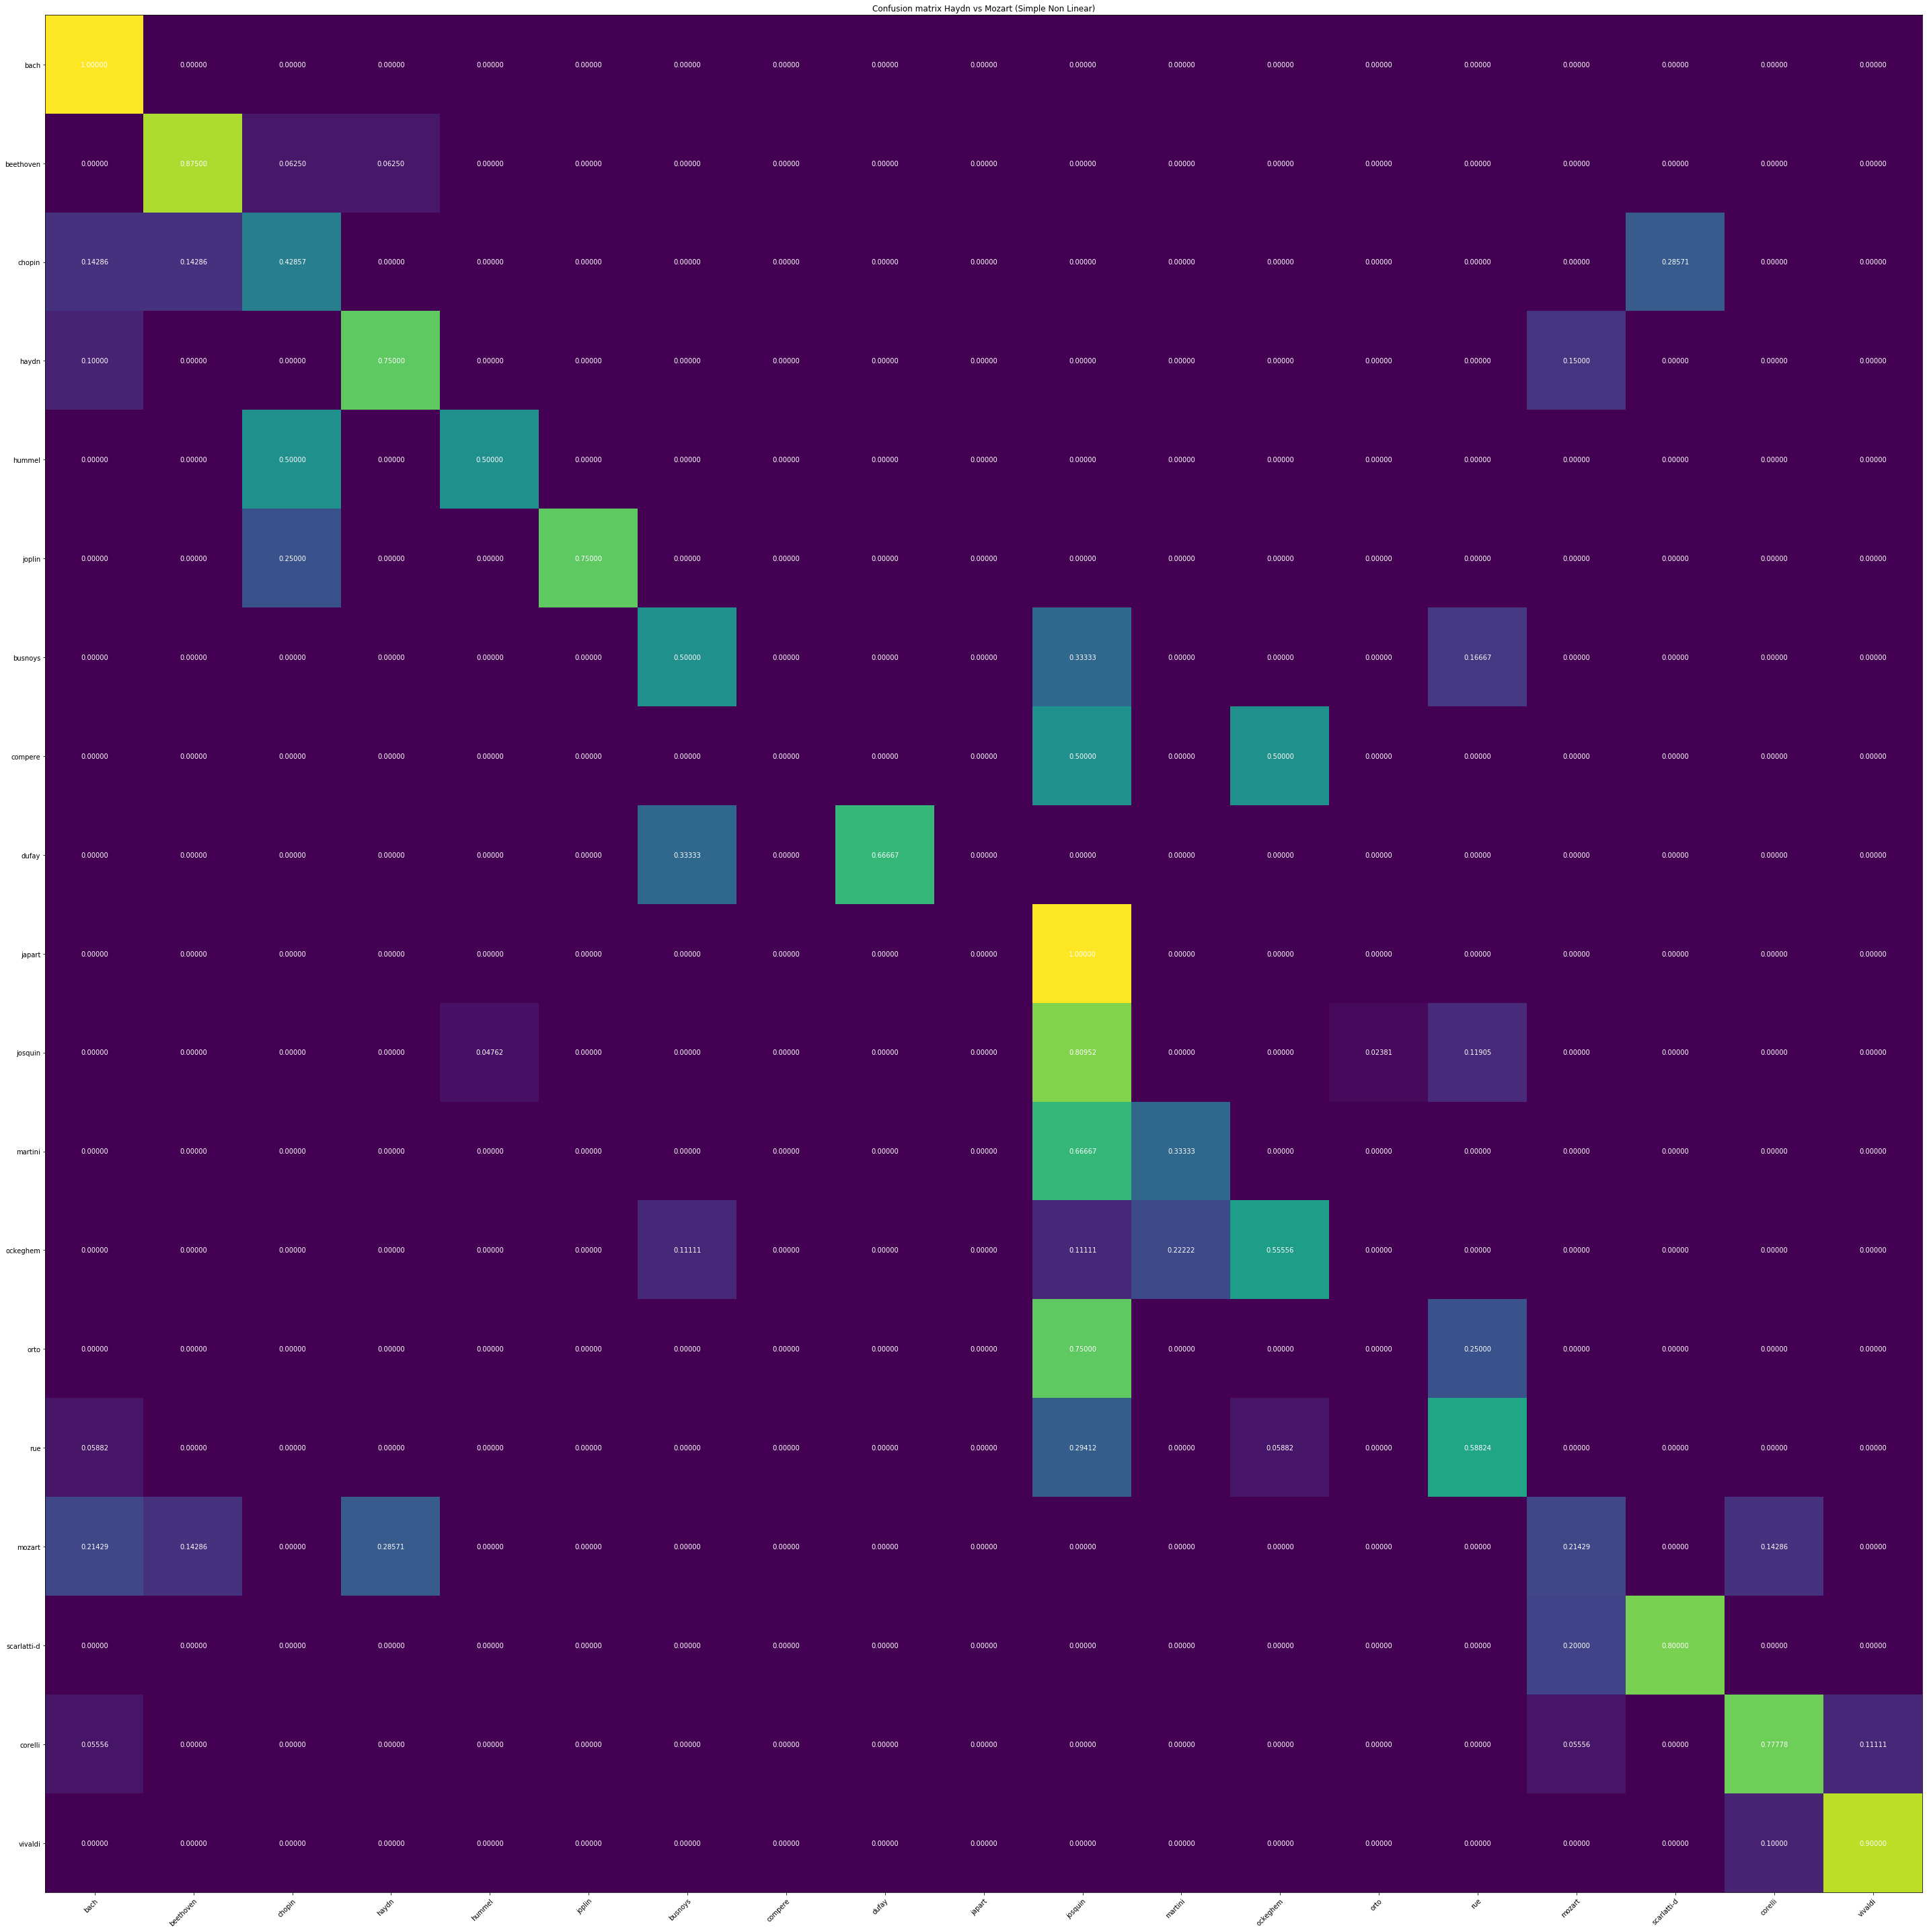

bach 46 / 46 = 1.0
beethoven 14 / 16 = 0.875
busnoys 3 / 6 = 0.5
chopin 3 / 7 = 0.42857142857142855
compere 0 / 2 = 0.0
corelli 14 / 18 = 0.7777777777777778
dufay 2 / 3 = 0.6666666666666666
haydn 15 / 20 = 0.75
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 3 / 4 = 0.75
josquin 34 / 42 = 0.8095238095238095
martini 4 / 12 = 0.3333333333333333
mozart 3 / 14 = 0.21428571428571427
ockeghem 5 / 9 = 0.5555555555555556
orto 0 / 4 = 0.0
rue 10 / 17 = 0.5882352941176471
scarlatti-d 4 / 5 = 0.8
vivaldi 9 / 10 = 0.9
170 239 0.7112970711297071
---------------------------------------------
---------------------------------------------
Fold 1
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
Initialized grap

96.00   73.22   4000    0.21    1.95    18.68   6.55    
96.50   74.48   4032    0.21    1.95    18.85   5.50    
97.00   74.06   4064    0.26    1.98    18.50   5.76    
97.00   74.06   4096    0.18    1.98    19.14   5.68    
97.00   75.73   4128    0.18    2.00    18.17   5.89    
96.50   74.90   4160    0.16    2.02    18.76   5.91    
97.00   74.48   4192    0.16    1.99    18.13   6.07    
97.00   76.15   4224    0.21    2.01    18.43   6.55    
96.50   74.48   4256    0.16    2.04    19.04   6.37    
96.00   75.31   4288    0.17    2.09    18.88   5.54    
96.50   75.31   4320    0.16    1.98    18.74   6.17    
96.50   74.90   4352    0.19    1.96    18.50   6.49    
96.50   74.90   4384    0.17    2.02    18.27   6.51    
97.00   74.90   4416    0.19    2.03    18.75   6.53    
97.00   75.31   4448    0.24    2.02    17.59   6.56    
97.00   75.31   4480    0.19    2.01    17.59   6.35    
97.00   74.90   4512    0.18    2.02    17.78   6.03    
97.00   75.73   4544    0.20   

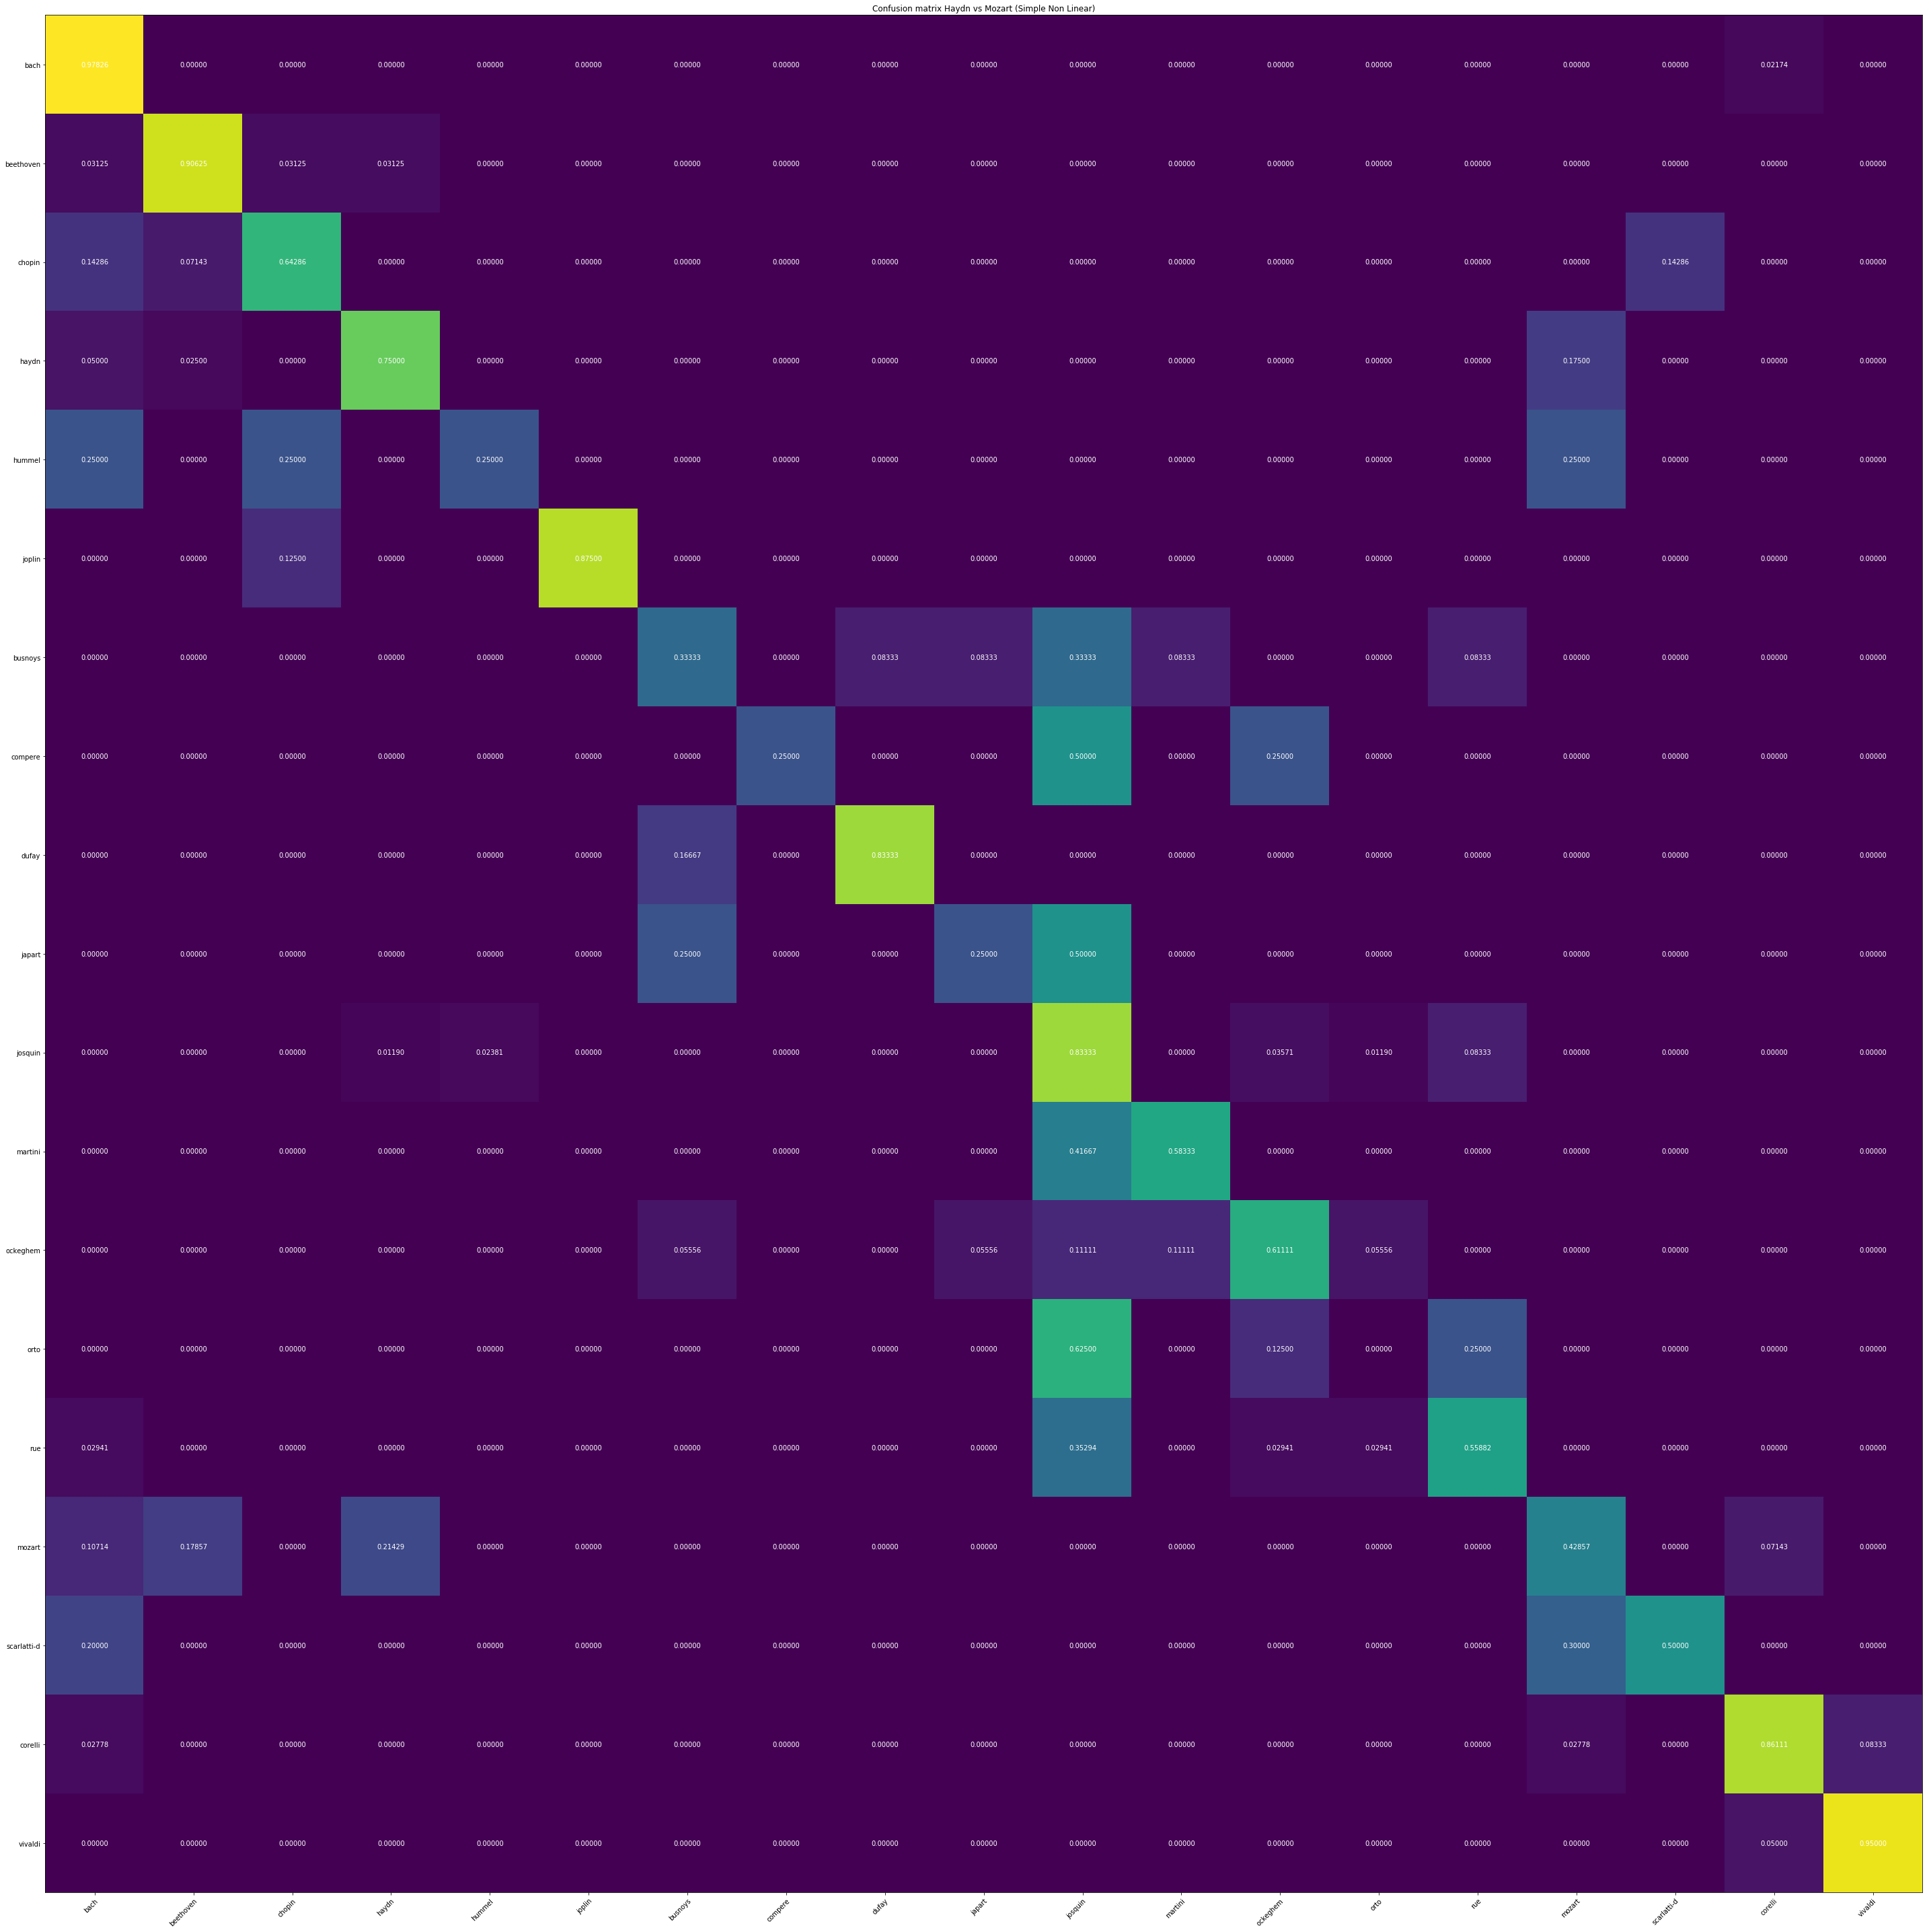

bach 44 / 46 = 0.9565217391304348
beethoven 15 / 16 = 0.9375
busnoys 1 / 6 = 0.16666666666666666
chopin 6 / 7 = 0.8571428571428571
compere 1 / 2 = 0.5
corelli 17 / 18 = 0.9444444444444444
dufay 3 / 3 = 1.0
haydn 15 / 20 = 0.75
hummel 0 / 2 = 0.0
japart 1 / 2 = 0.5
joplin 4 / 4 = 1.0
josquin 36 / 42 = 0.8571428571428571
martini 10 / 12 = 0.8333333333333334
mozart 9 / 14 = 0.6428571428571429
ockeghem 6 / 9 = 0.6666666666666666
orto 0 / 4 = 0.0
rue 9 / 17 = 0.5294117647058824
scarlatti-d 1 / 5 = 0.2
vivaldi 10 / 10 = 1.0
188 239 0.7866108786610879
---------------------------------------------
---------------------------------------------
Fold 2
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
I

96.00   75.31   3968    0.19    1.93    18.19   5.79    
96.00   75.31   4000    0.24    1.92    18.39   6.36    
96.50   75.73   4032    0.18    1.96    18.50   6.09    
96.50   76.57   4064    0.19    1.97    19.16   6.23    
94.50   75.73   4096    0.32    1.96    18.11   6.41    
96.00   75.73   4128    0.24    1.96    18.73   6.48    
96.00   74.48   4160    0.18    1.98    18.01   6.00    
96.50   76.57   4192    0.17    1.88    18.44   6.47    
96.50   76.57   4224    0.20    1.92    18.62   6.18    
96.00   76.57   4256    0.19    1.96    18.34   6.77    
94.50   73.64   4288    0.21    2.01    17.58   6.13    
96.00   76.57   4320    0.19    1.95    19.34   6.22    
95.50   75.31   4352    0.18    1.98    19.30   6.30    
96.00   76.57   4384    0.18    2.01    19.06   6.01    
96.50   77.41   4416    0.22    2.05    19.66   6.60    
96.50   76.15   4448    0.16    2.02    18.72   5.82    
97.00   76.99   4480    0.20    2.02    19.43   6.63    
97.00   76.57   4512    0.19   

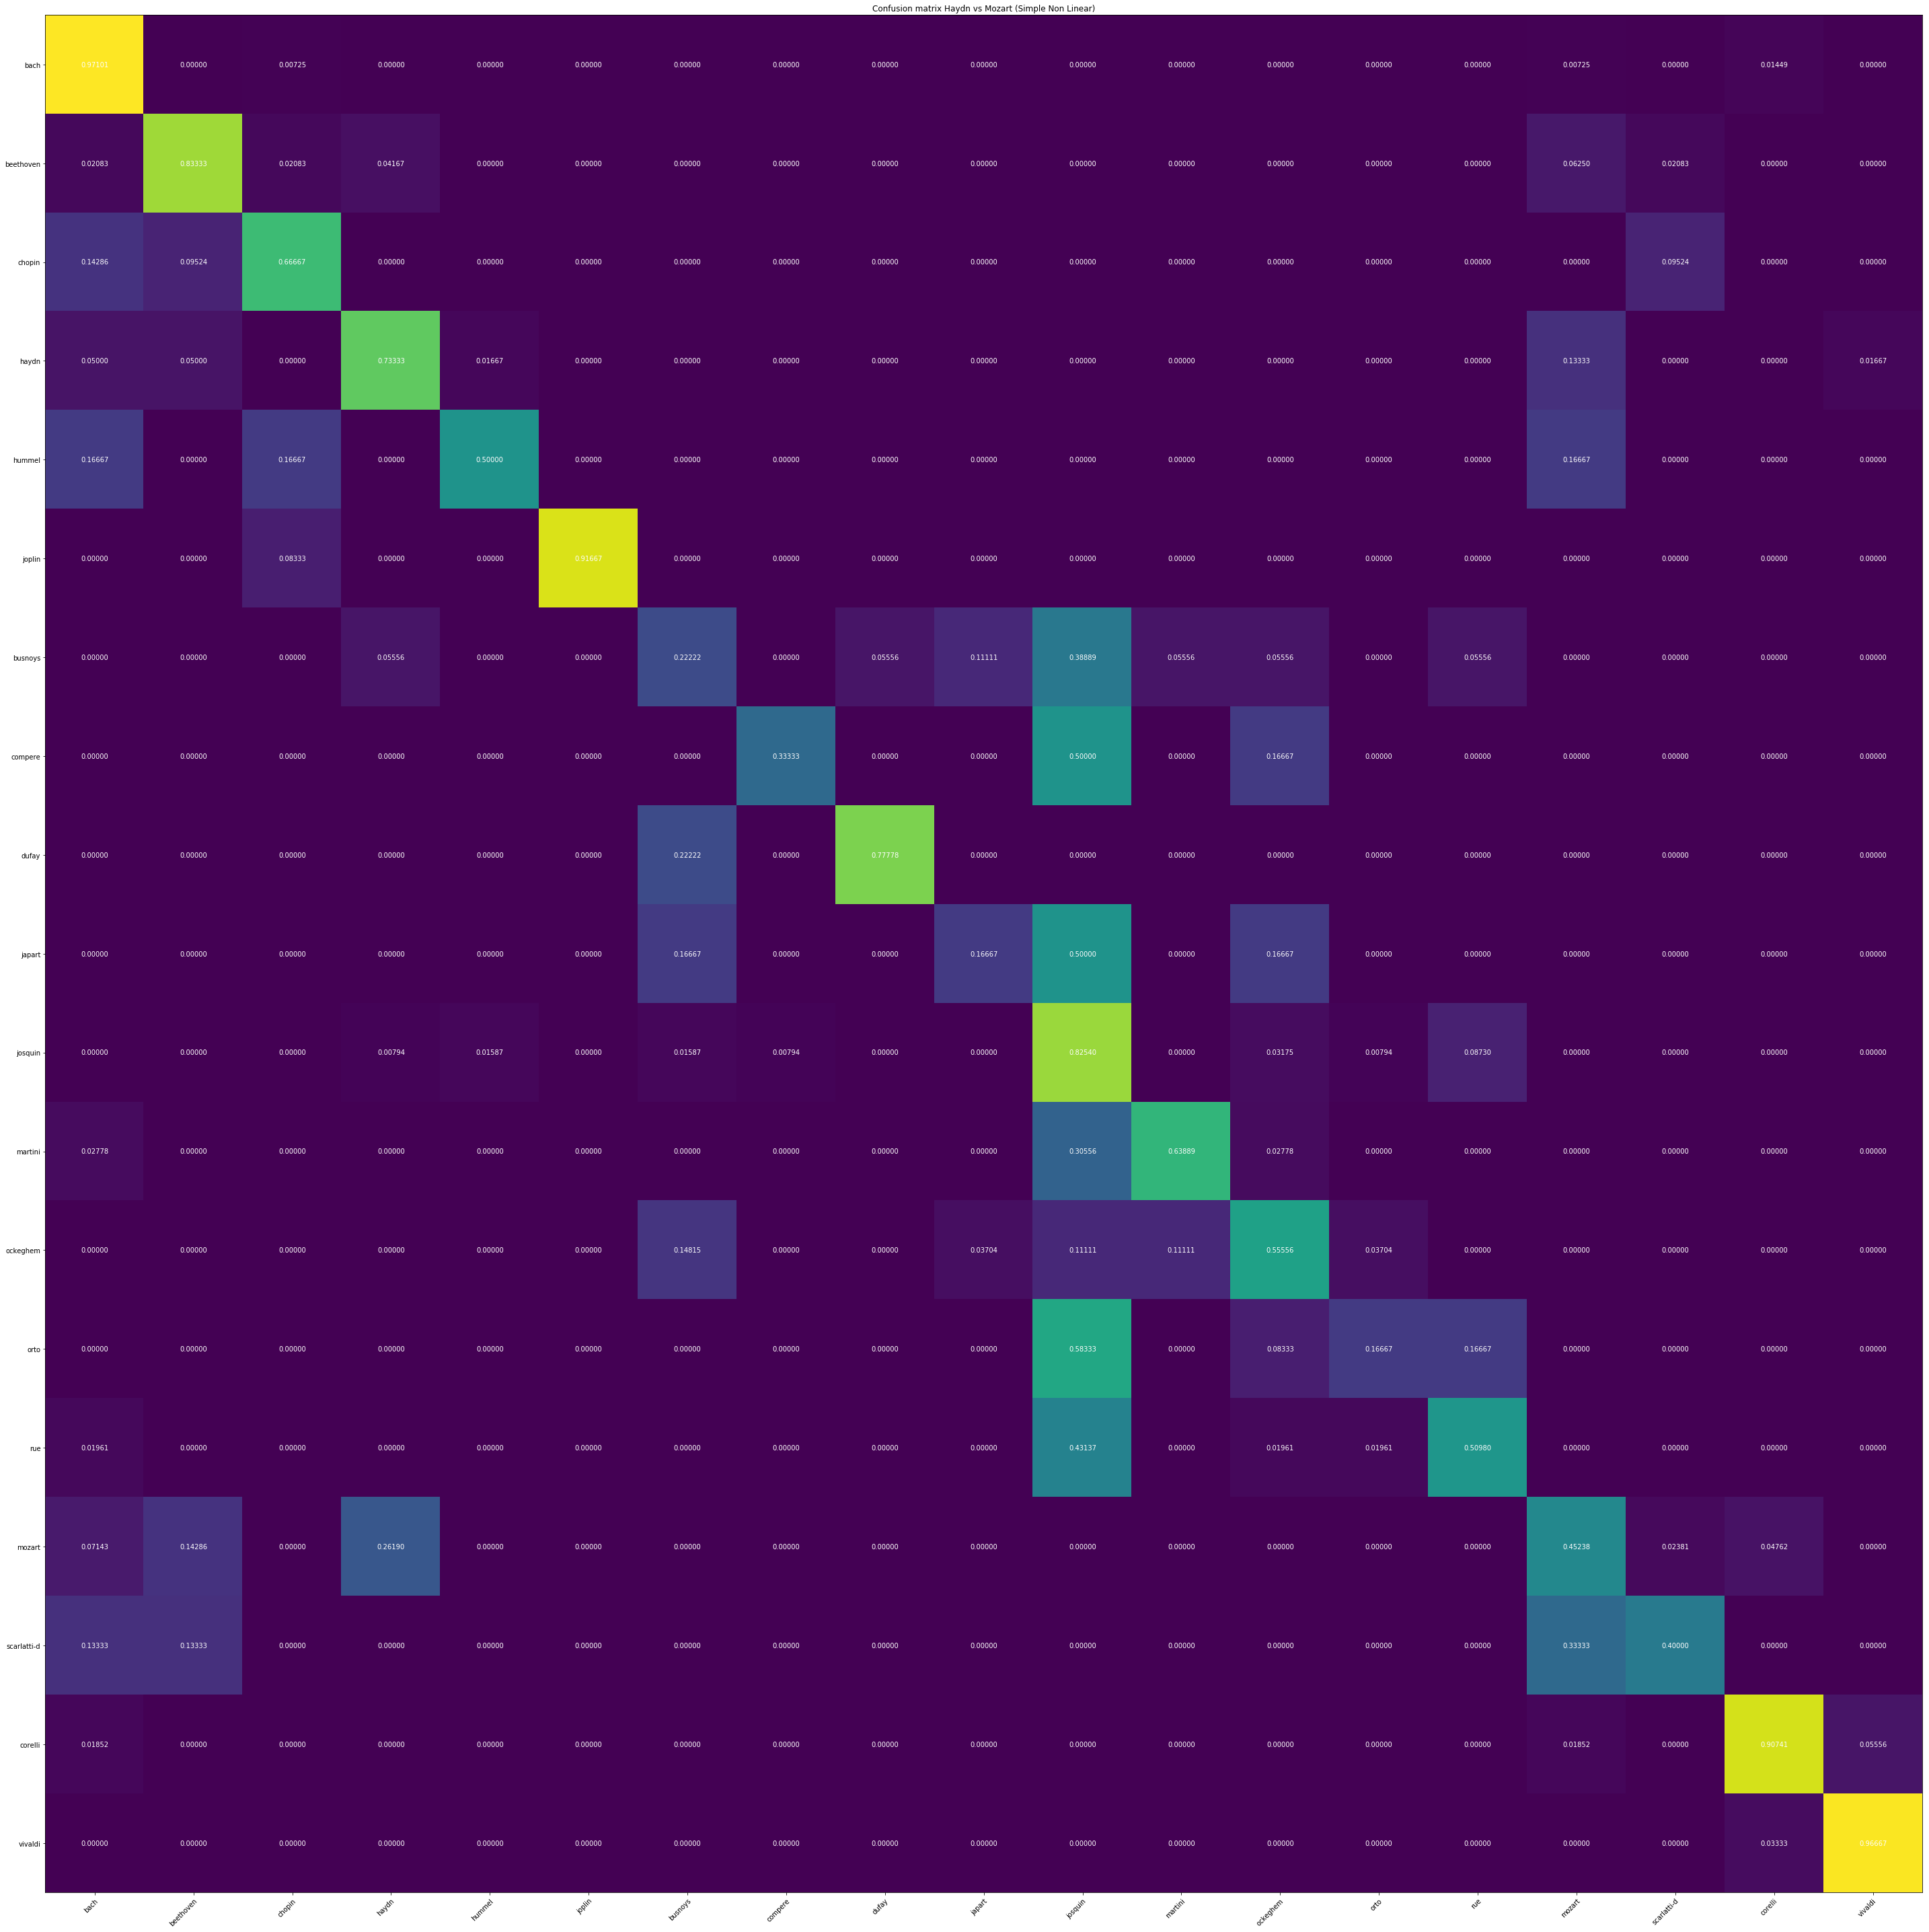

bach 44 / 46 = 0.9565217391304348
beethoven 11 / 16 = 0.6875
busnoys 0 / 6 = 0.0
chopin 5 / 7 = 0.7142857142857143
compere 1 / 2 = 0.5
corelli 18 / 18 = 1.0
dufay 2 / 3 = 0.6666666666666666
haydn 14 / 20 = 0.7
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 34 / 42 = 0.8095238095238095
martini 9 / 12 = 0.75
mozart 7 / 14 = 0.5
ockeghem 4 / 9 = 0.4444444444444444
orto 2 / 4 = 0.5
rue 7 / 17 = 0.4117647058823529
scarlatti-d 1 / 5 = 0.2
vivaldi 10 / 10 = 1.0
175 239 0.7322175732217573
---------------------------------------------
---------------------------------------------
Fold 3
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
Initialized graph with 209019 parameters
Initiat

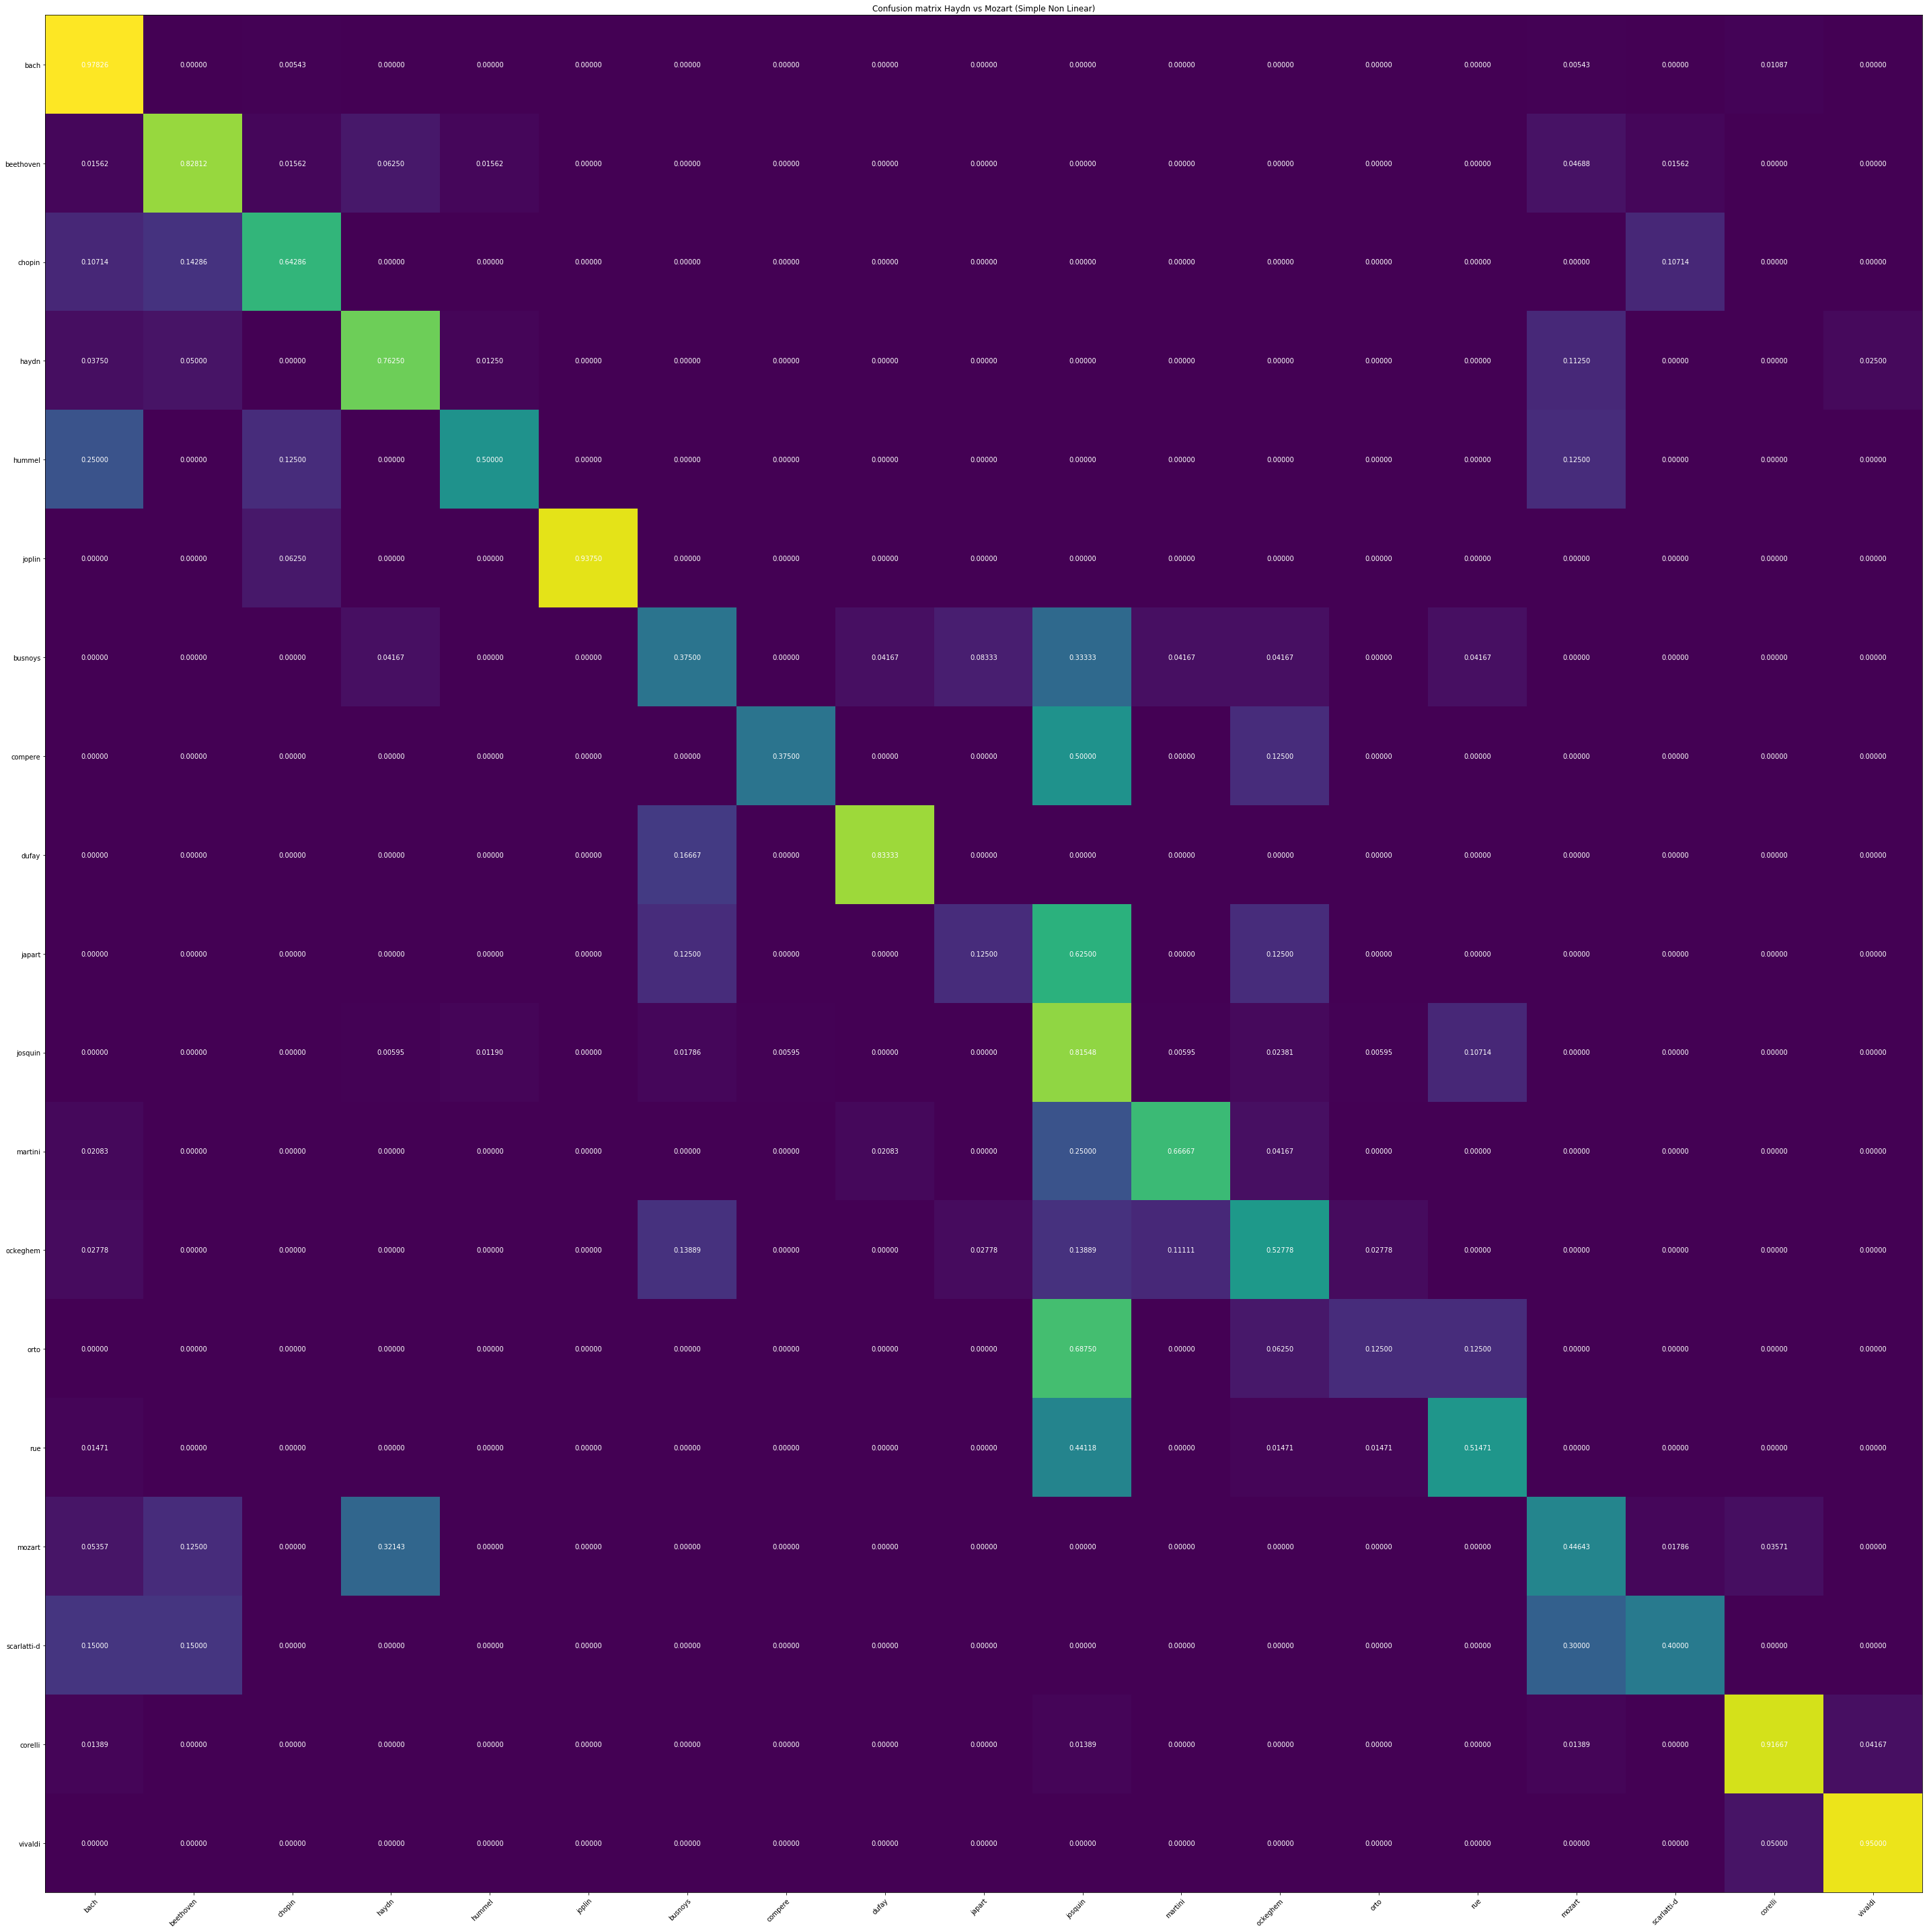

bach 46 / 46 = 1.0
beethoven 13 / 16 = 0.8125
busnoys 5 / 6 = 0.8333333333333334
chopin 4 / 7 = 0.5714285714285714
compere 1 / 2 = 0.5
corelli 17 / 18 = 0.9444444444444444
dufay 3 / 3 = 1.0
haydn 17 / 20 = 0.85
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 33 / 42 = 0.7857142857142857
martini 9 / 12 = 0.75
mozart 6 / 14 = 0.42857142857142855
ockeghem 4 / 9 = 0.4444444444444444
orto 0 / 4 = 0.0
rue 9 / 17 = 0.5294117647058824
scarlatti-d 2 / 5 = 0.4
vivaldi 9 / 10 = 0.9
183 239 0.7656903765690377
---------------------------------------------
---------------------------------------------
Fold 4
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
Initialized graph with 209019 pa

98.00   77.82   4000    0.26    1.42    18.80   6.21    
98.00   76.99   4032    0.18    1.42    19.15   5.98    
97.00   77.41   4064    0.22    1.41    18.97   5.63    
Finished
**************
Test accuracy :  0.7698744769874477


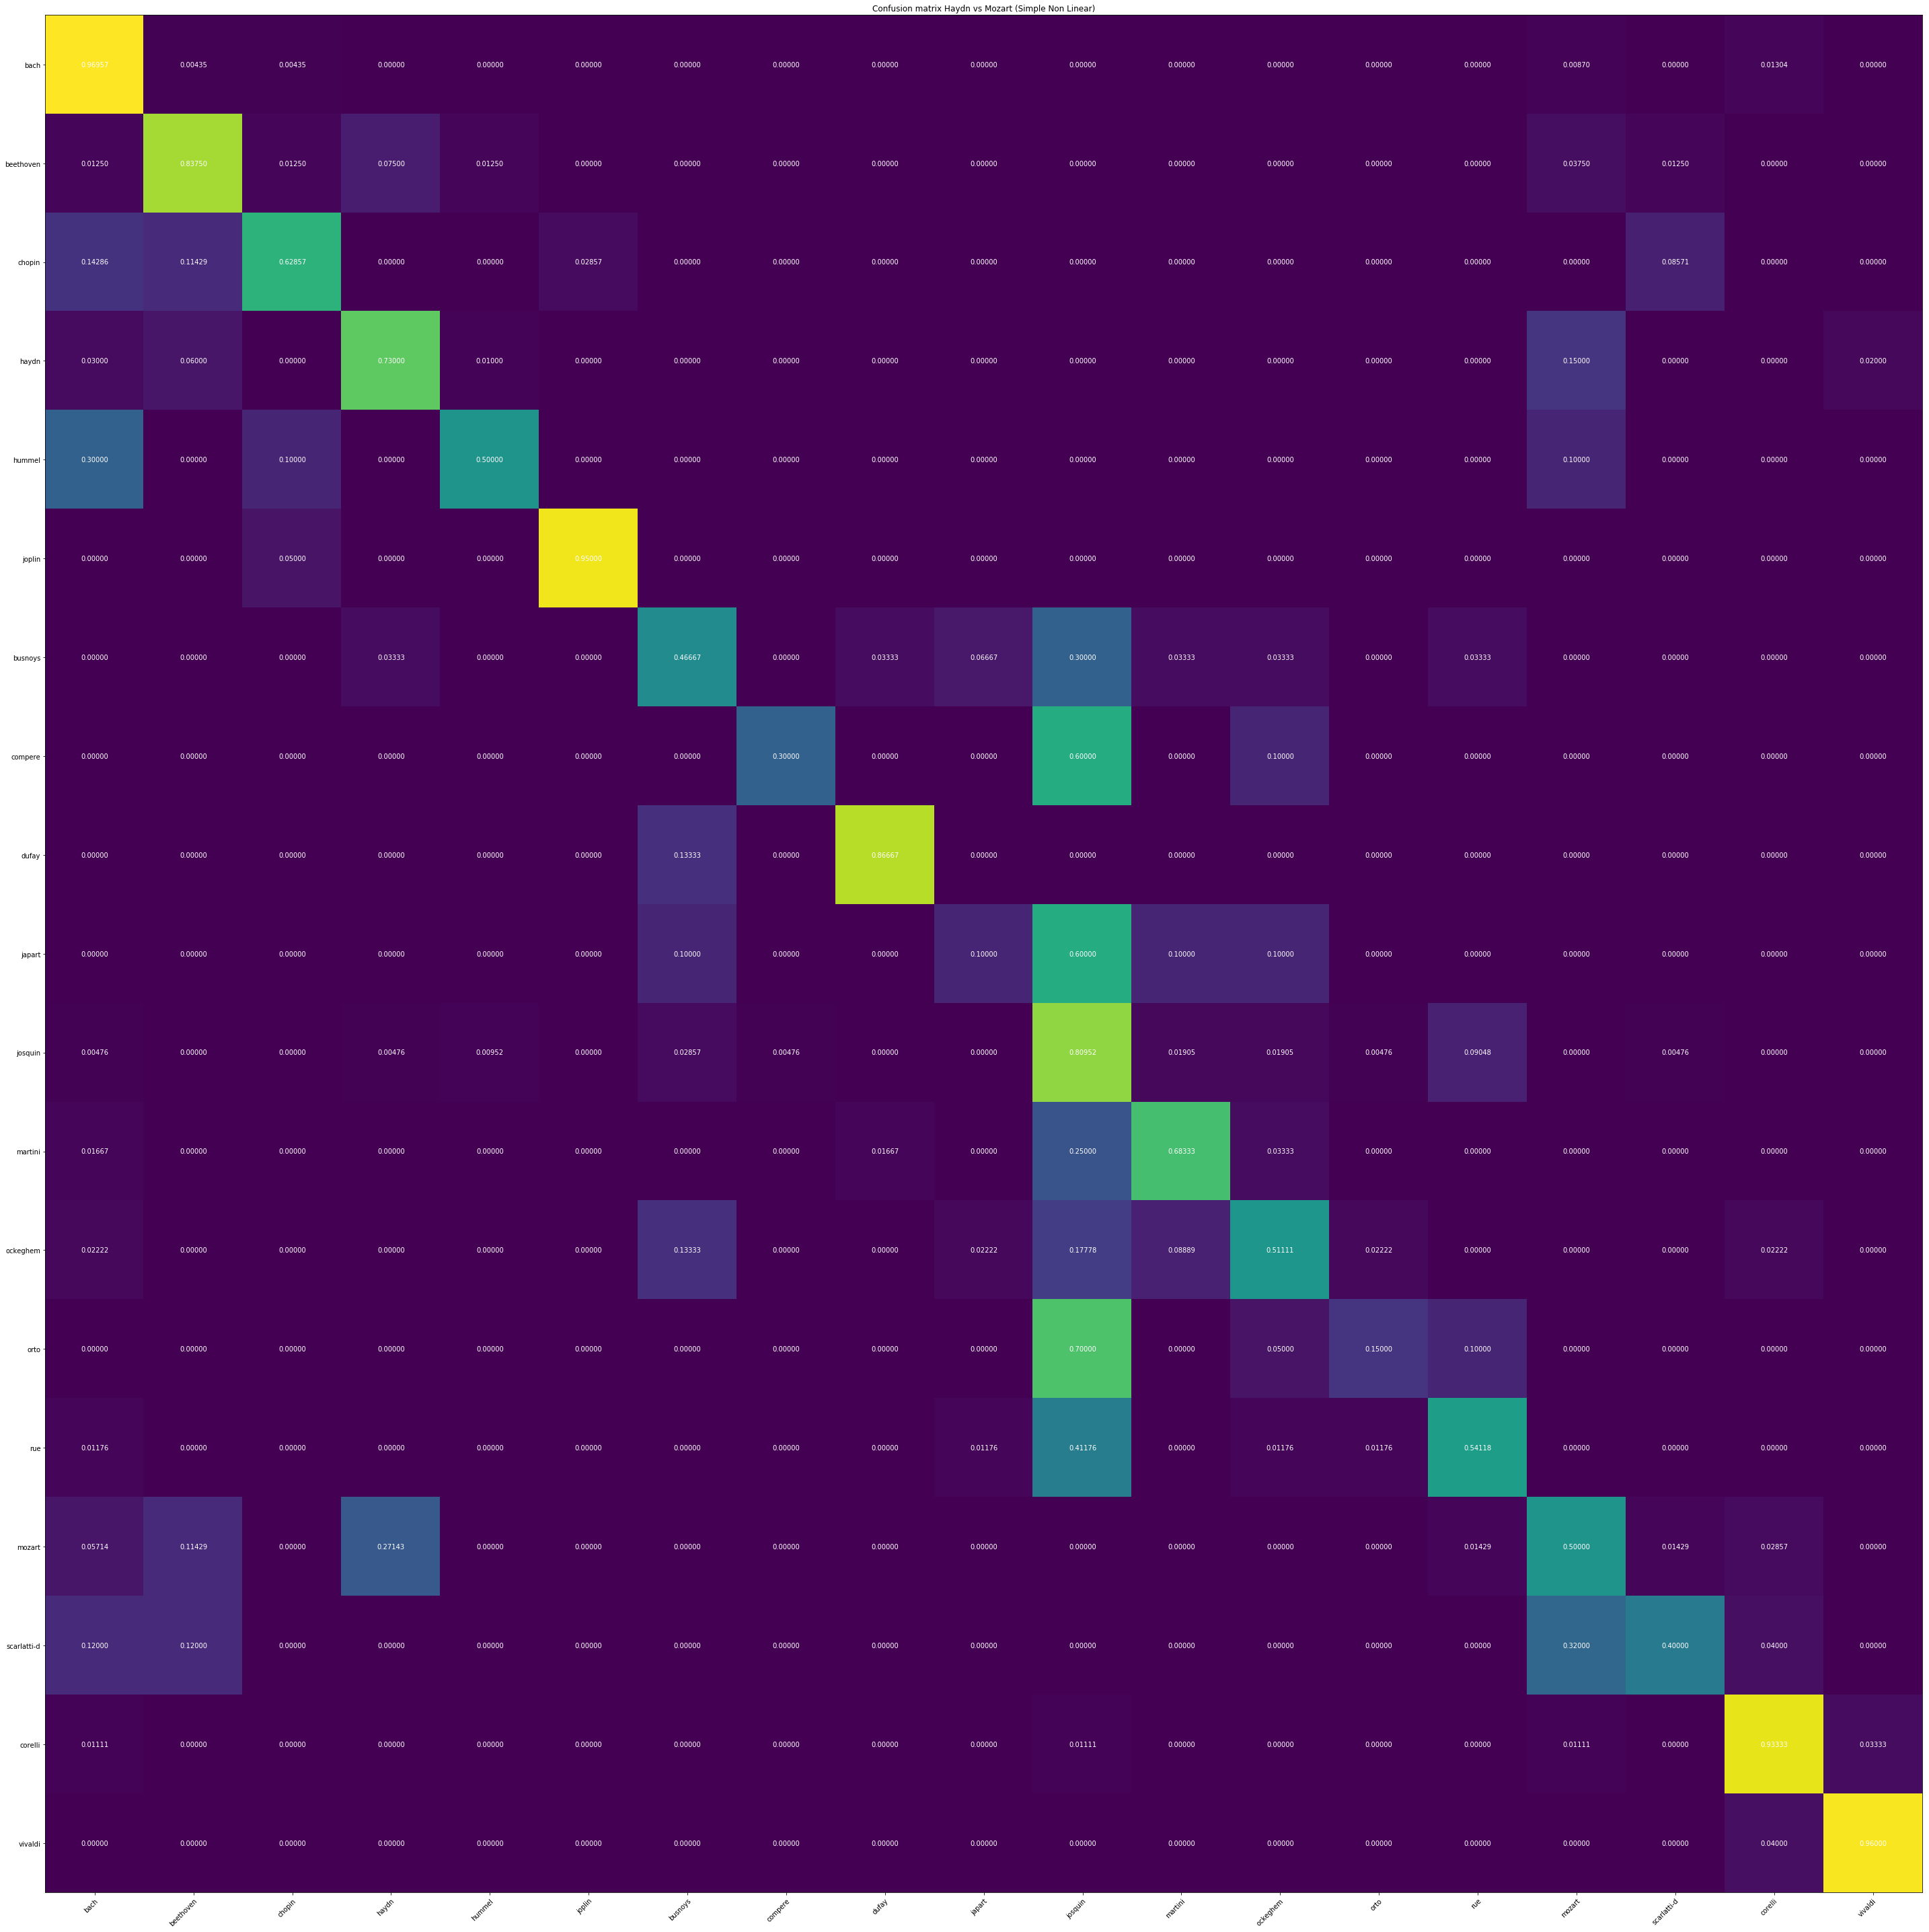

bach 43 / 46 = 0.9347826086956522
beethoven 14 / 16 = 0.875
busnoys 5 / 6 = 0.8333333333333334
chopin 4 / 7 = 0.5714285714285714
compere 0 / 2 = 0.0
corelli 18 / 18 = 1.0
dufay 3 / 3 = 1.0
haydn 12 / 20 = 0.6
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 33 / 42 = 0.7857142857142857
martini 9 / 12 = 0.75
mozart 10 / 14 = 0.7142857142857143
ockeghem 4 / 9 = 0.4444444444444444
orto 1 / 4 = 0.25
rue 11 / 17 = 0.6470588235294118
scarlatti-d 2 / 5 = 0.4
vivaldi 10 / 10 = 1.0
184 239 0.7698744769874477
---------------------------------------------
---------------------------------------------
Fold 5
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
Initialized graph with 209019 p

97.00   78.24   4000    0.18    1.39    18.71   6.89    
97.50   76.15   4032    0.16    1.39    19.15   7.14    
98.00   77.82   4064    0.17    1.39    17.54   6.65    
97.50   76.57   4096    0.15    1.42    18.31   6.66    
98.00   77.82   4128    0.17    1.42    18.58   6.44    
97.50   77.41   4160    0.17    1.44    18.58   6.47    
98.50   77.41   4192    0.14    1.43    18.74   6.58    
99.00   78.24   4224    0.18    1.44    18.57   6.40    
98.50   77.41   4256    0.24    1.46    17.89   5.92    
Finished
**************
Test accuracy :  0.7698744769874477


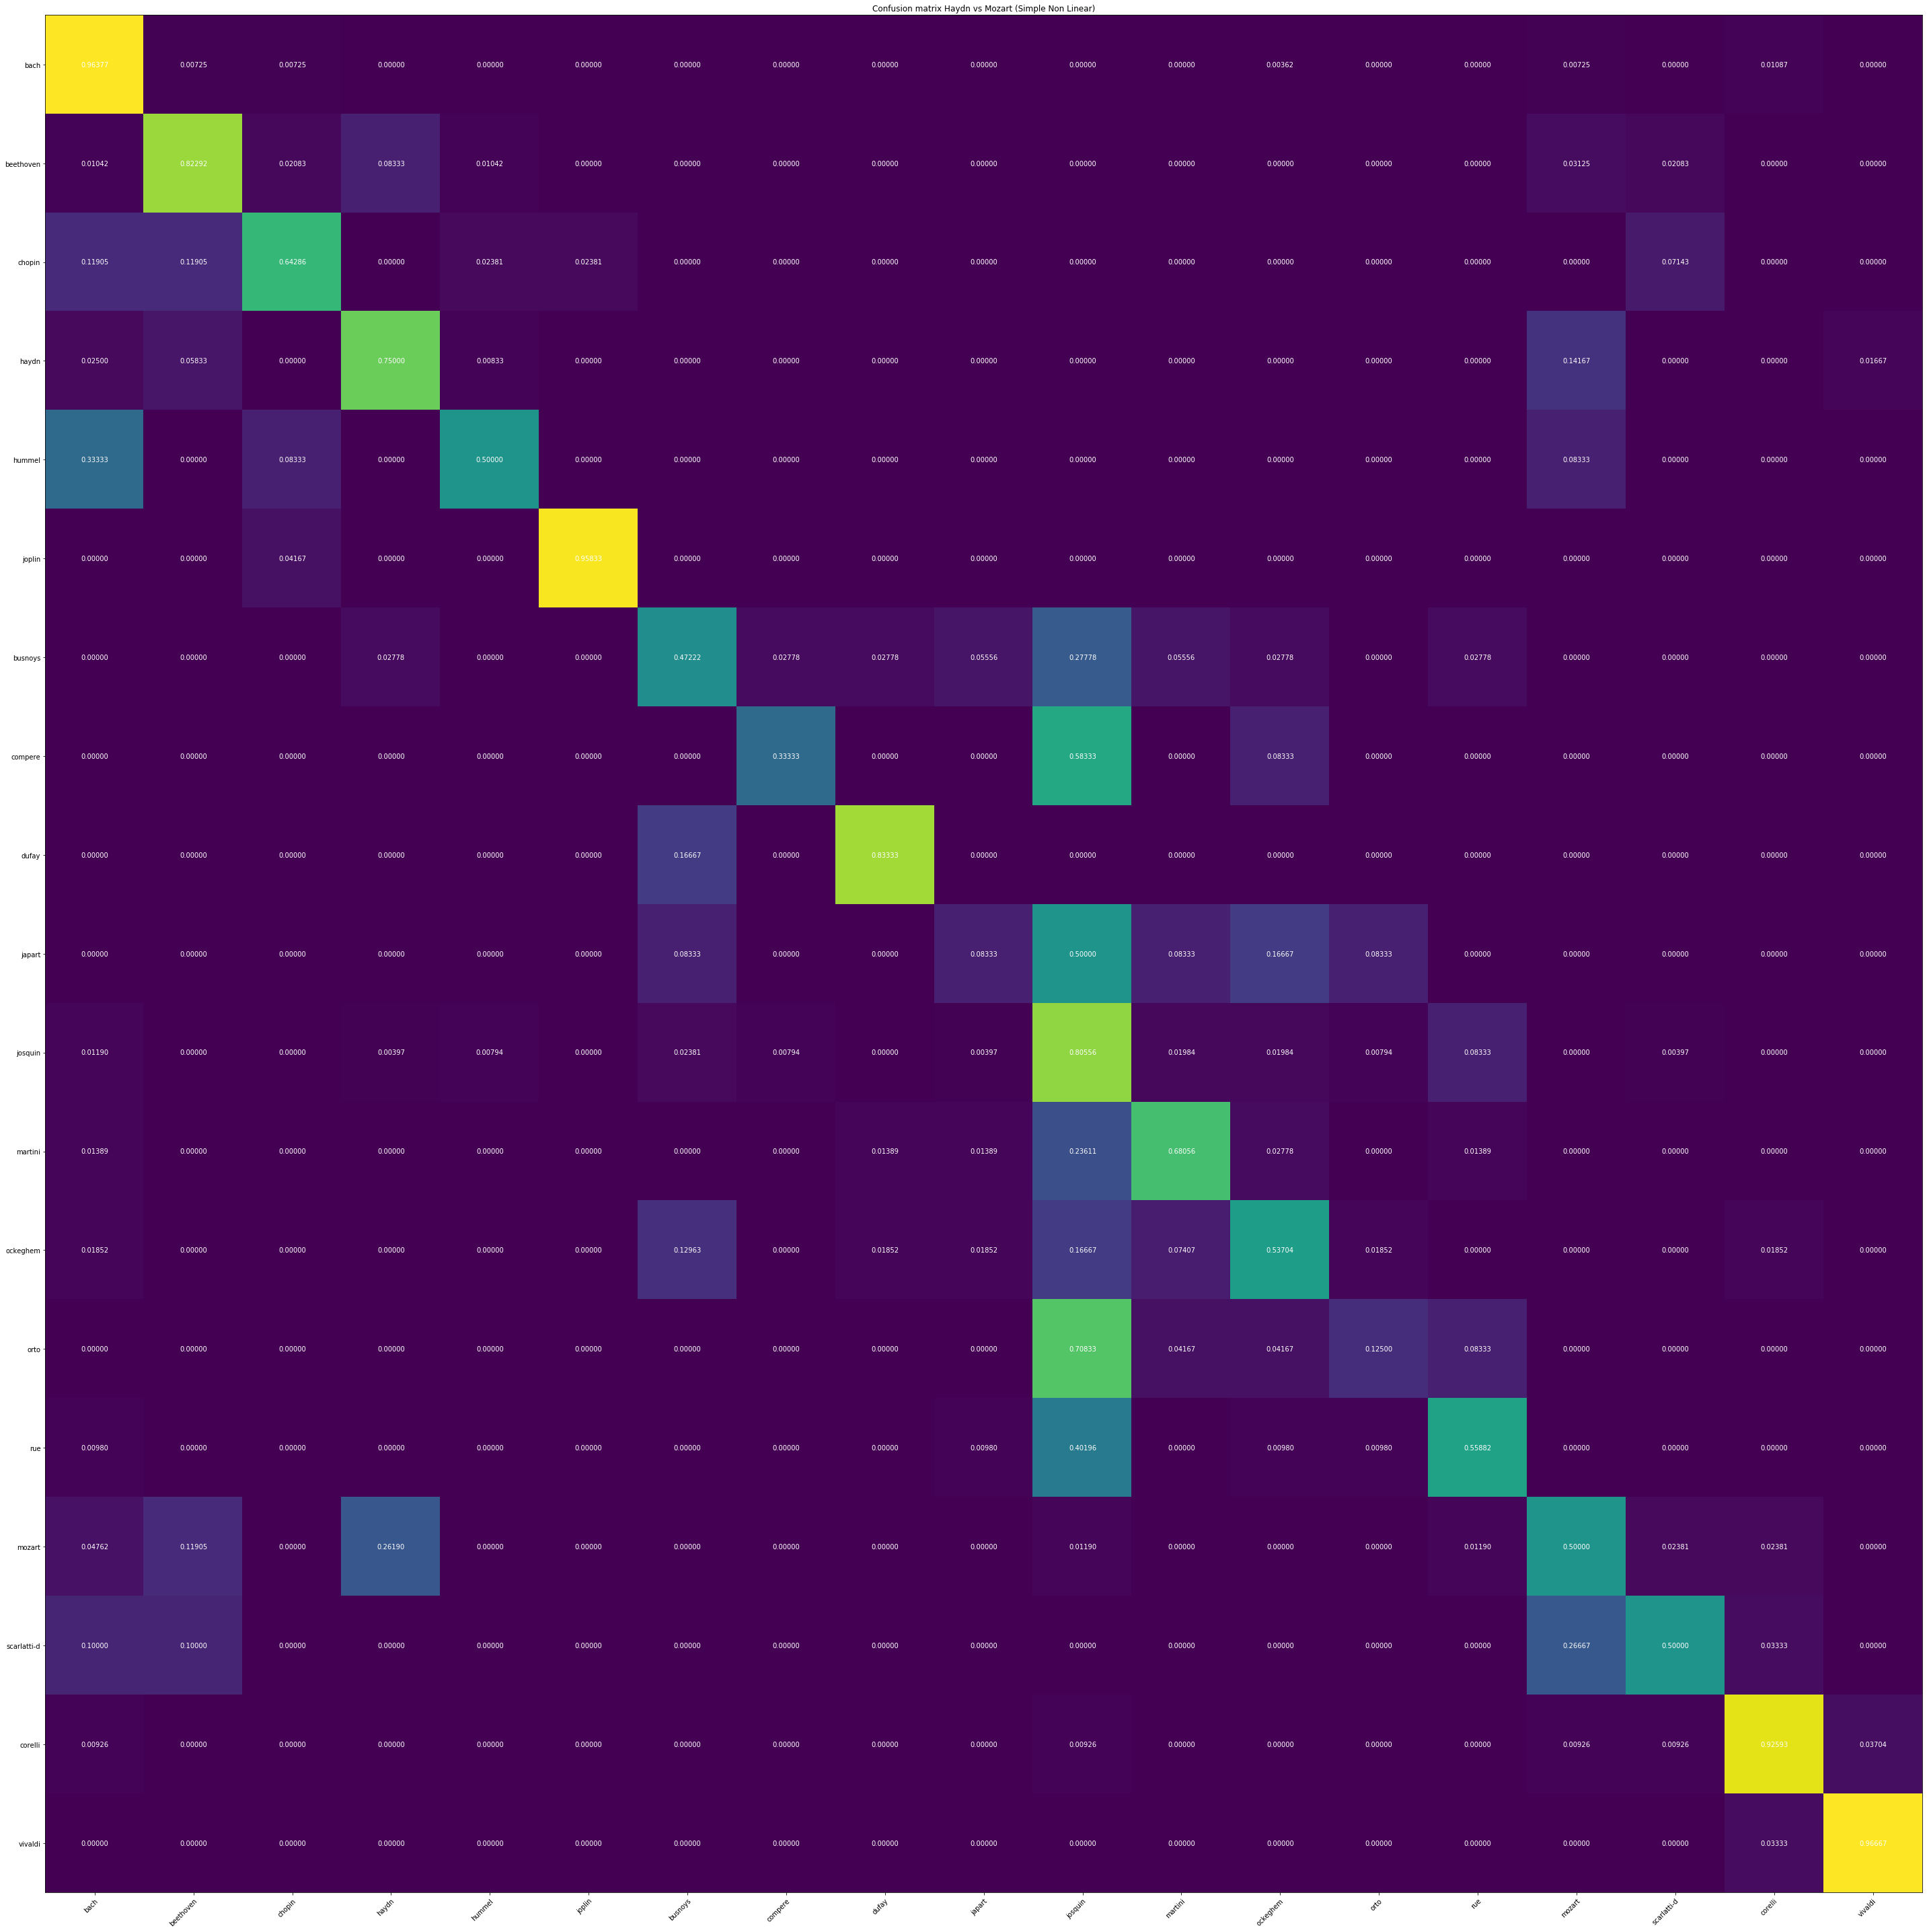

bach 43 / 46 = 0.9347826086956522
beethoven 12 / 16 = 0.75
busnoys 3 / 6 = 0.5
chopin 5 / 7 = 0.7142857142857143
compere 1 / 2 = 0.5
corelli 16 / 18 = 0.8888888888888888
dufay 2 / 3 = 0.6666666666666666
haydn 17 / 20 = 0.85
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 33 / 42 = 0.7857142857142857
martini 8 / 12 = 0.6666666666666666
mozart 7 / 14 = 0.5
ockeghem 6 / 9 = 0.6666666666666666
orto 0 / 4 = 0.0
rue 11 / 17 = 0.6470588235294118
scarlatti-d 5 / 5 = 1.0
vivaldi 10 / 10 = 1.0
184 239 0.7698744769874477
---------------------------------------------
---------------------------------------------
Fold 6
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
Initialized graph w

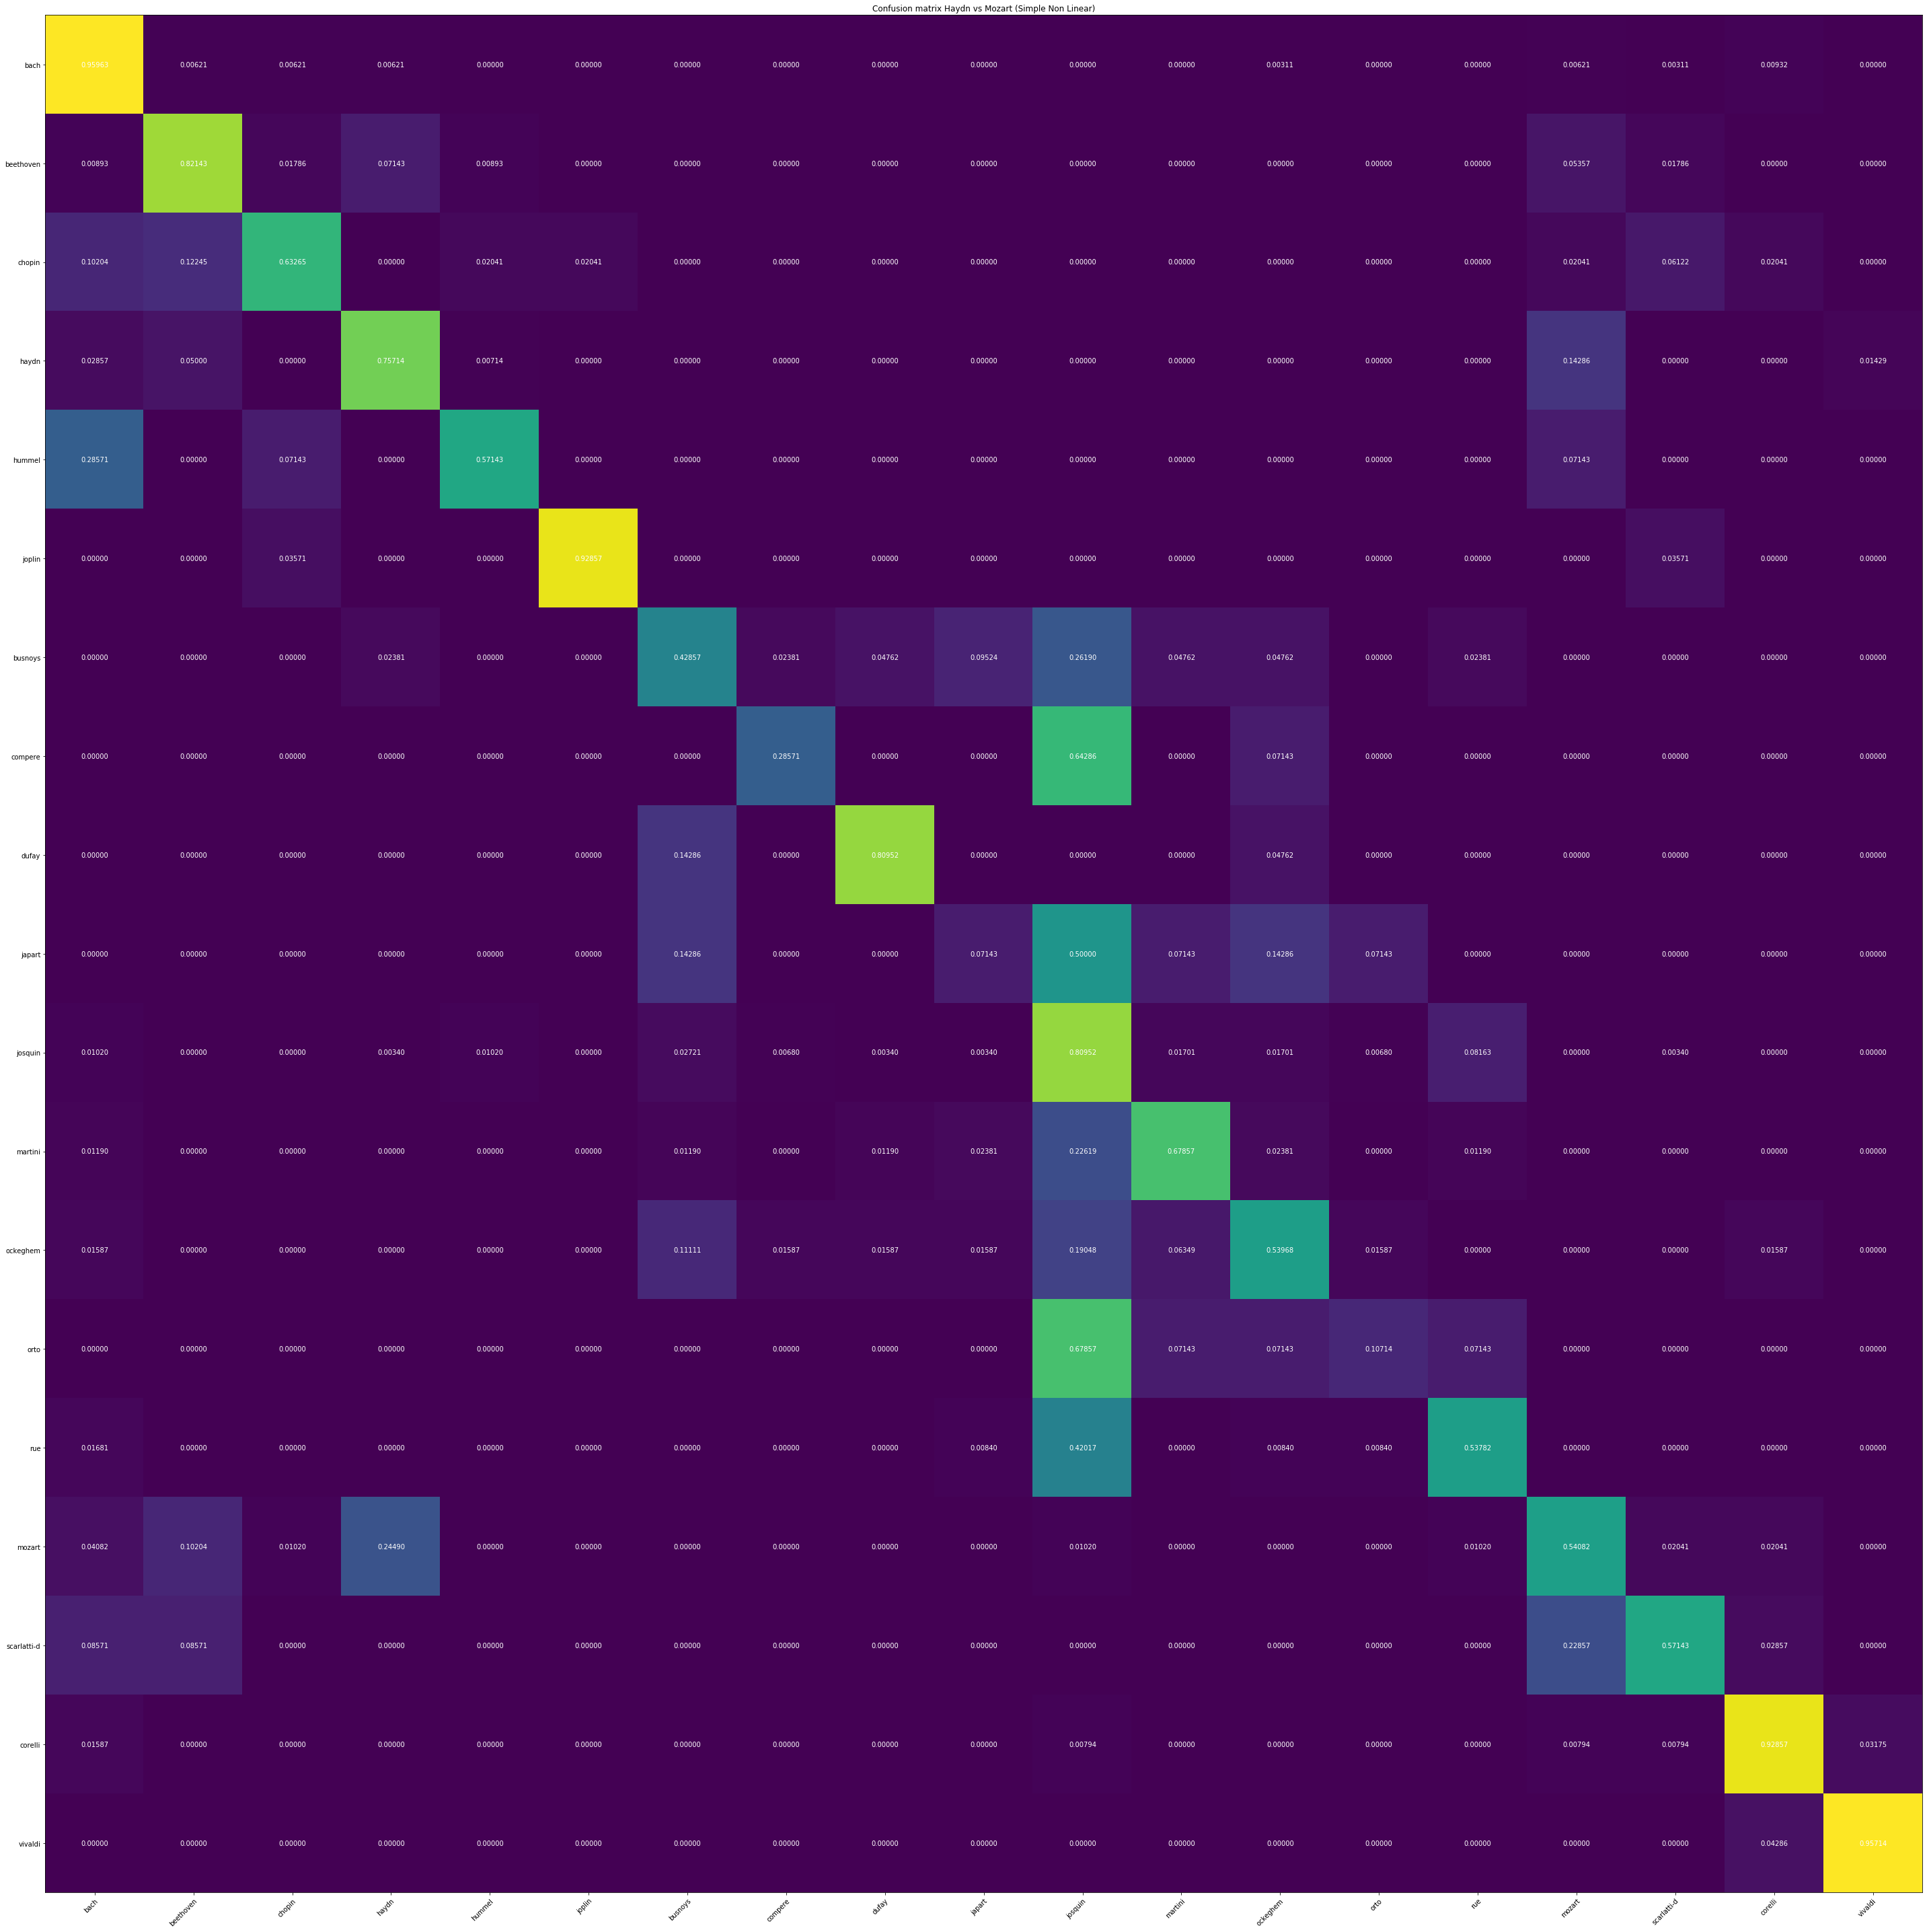

bach 43 / 46 = 0.9347826086956522
beethoven 13 / 16 = 0.8125
busnoys 1 / 6 = 0.16666666666666666
chopin 4 / 7 = 0.5714285714285714
compere 0 / 2 = 0.0
corelli 17 / 18 = 0.9444444444444444
dufay 2 / 3 = 0.6666666666666666
haydn 16 / 20 = 0.8
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 3 / 4 = 0.75
josquin 35 / 42 = 0.8333333333333334
martini 8 / 12 = 0.6666666666666666
mozart 11 / 14 = 0.7857142857142857
ockeghem 5 / 9 = 0.5555555555555556
orto 0 / 4 = 0.0
rue 7 / 17 = 0.4117647058823529
scarlatti-d 5 / 5 = 1.0
vivaldi 9 / 10 = 0.9
181 239 0.7573221757322176
---------------------------------------------
---------------------------------------------
Fold 7
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Siz

97.50   77.82   3968    0.25    1.24    18.98   6.00    
97.50   77.82   4000    0.28    1.26    17.92   5.71    
97.00   77.41   4032    0.19    1.25    18.35   6.23    
96.50   78.24   4064    0.17    1.27    18.56   6.37    
97.00   78.24   4096    0.17    1.29    19.49   6.10    
97.50   77.41   4128    0.19    1.29    18.33   6.07    
97.00   77.41   4160    0.36    1.27    18.22   5.75    
97.00   77.41   4192    0.18    1.29    19.40   6.23    
97.00   78.66   4224    0.16    1.28    19.39   5.87    
97.00   78.66   4256    0.20    1.29    18.64   6.22    
97.50   77.82   4288    0.24    1.29    18.66   6.16    
97.50   77.82   4320    0.24    1.28    19.11   6.17    
97.50   78.24   4352    0.22    1.30    18.17   6.16    
97.50   77.82   4384    0.17    1.31    19.33   6.67    
97.00   77.41   4416    0.16    1.31    18.18   6.58    
97.50   78.66   4448    0.16    1.31    18.06   6.27    
97.50   79.08   4480    0.18    1.31    18.18   6.16    
96.00   78.24   4512    0.19   

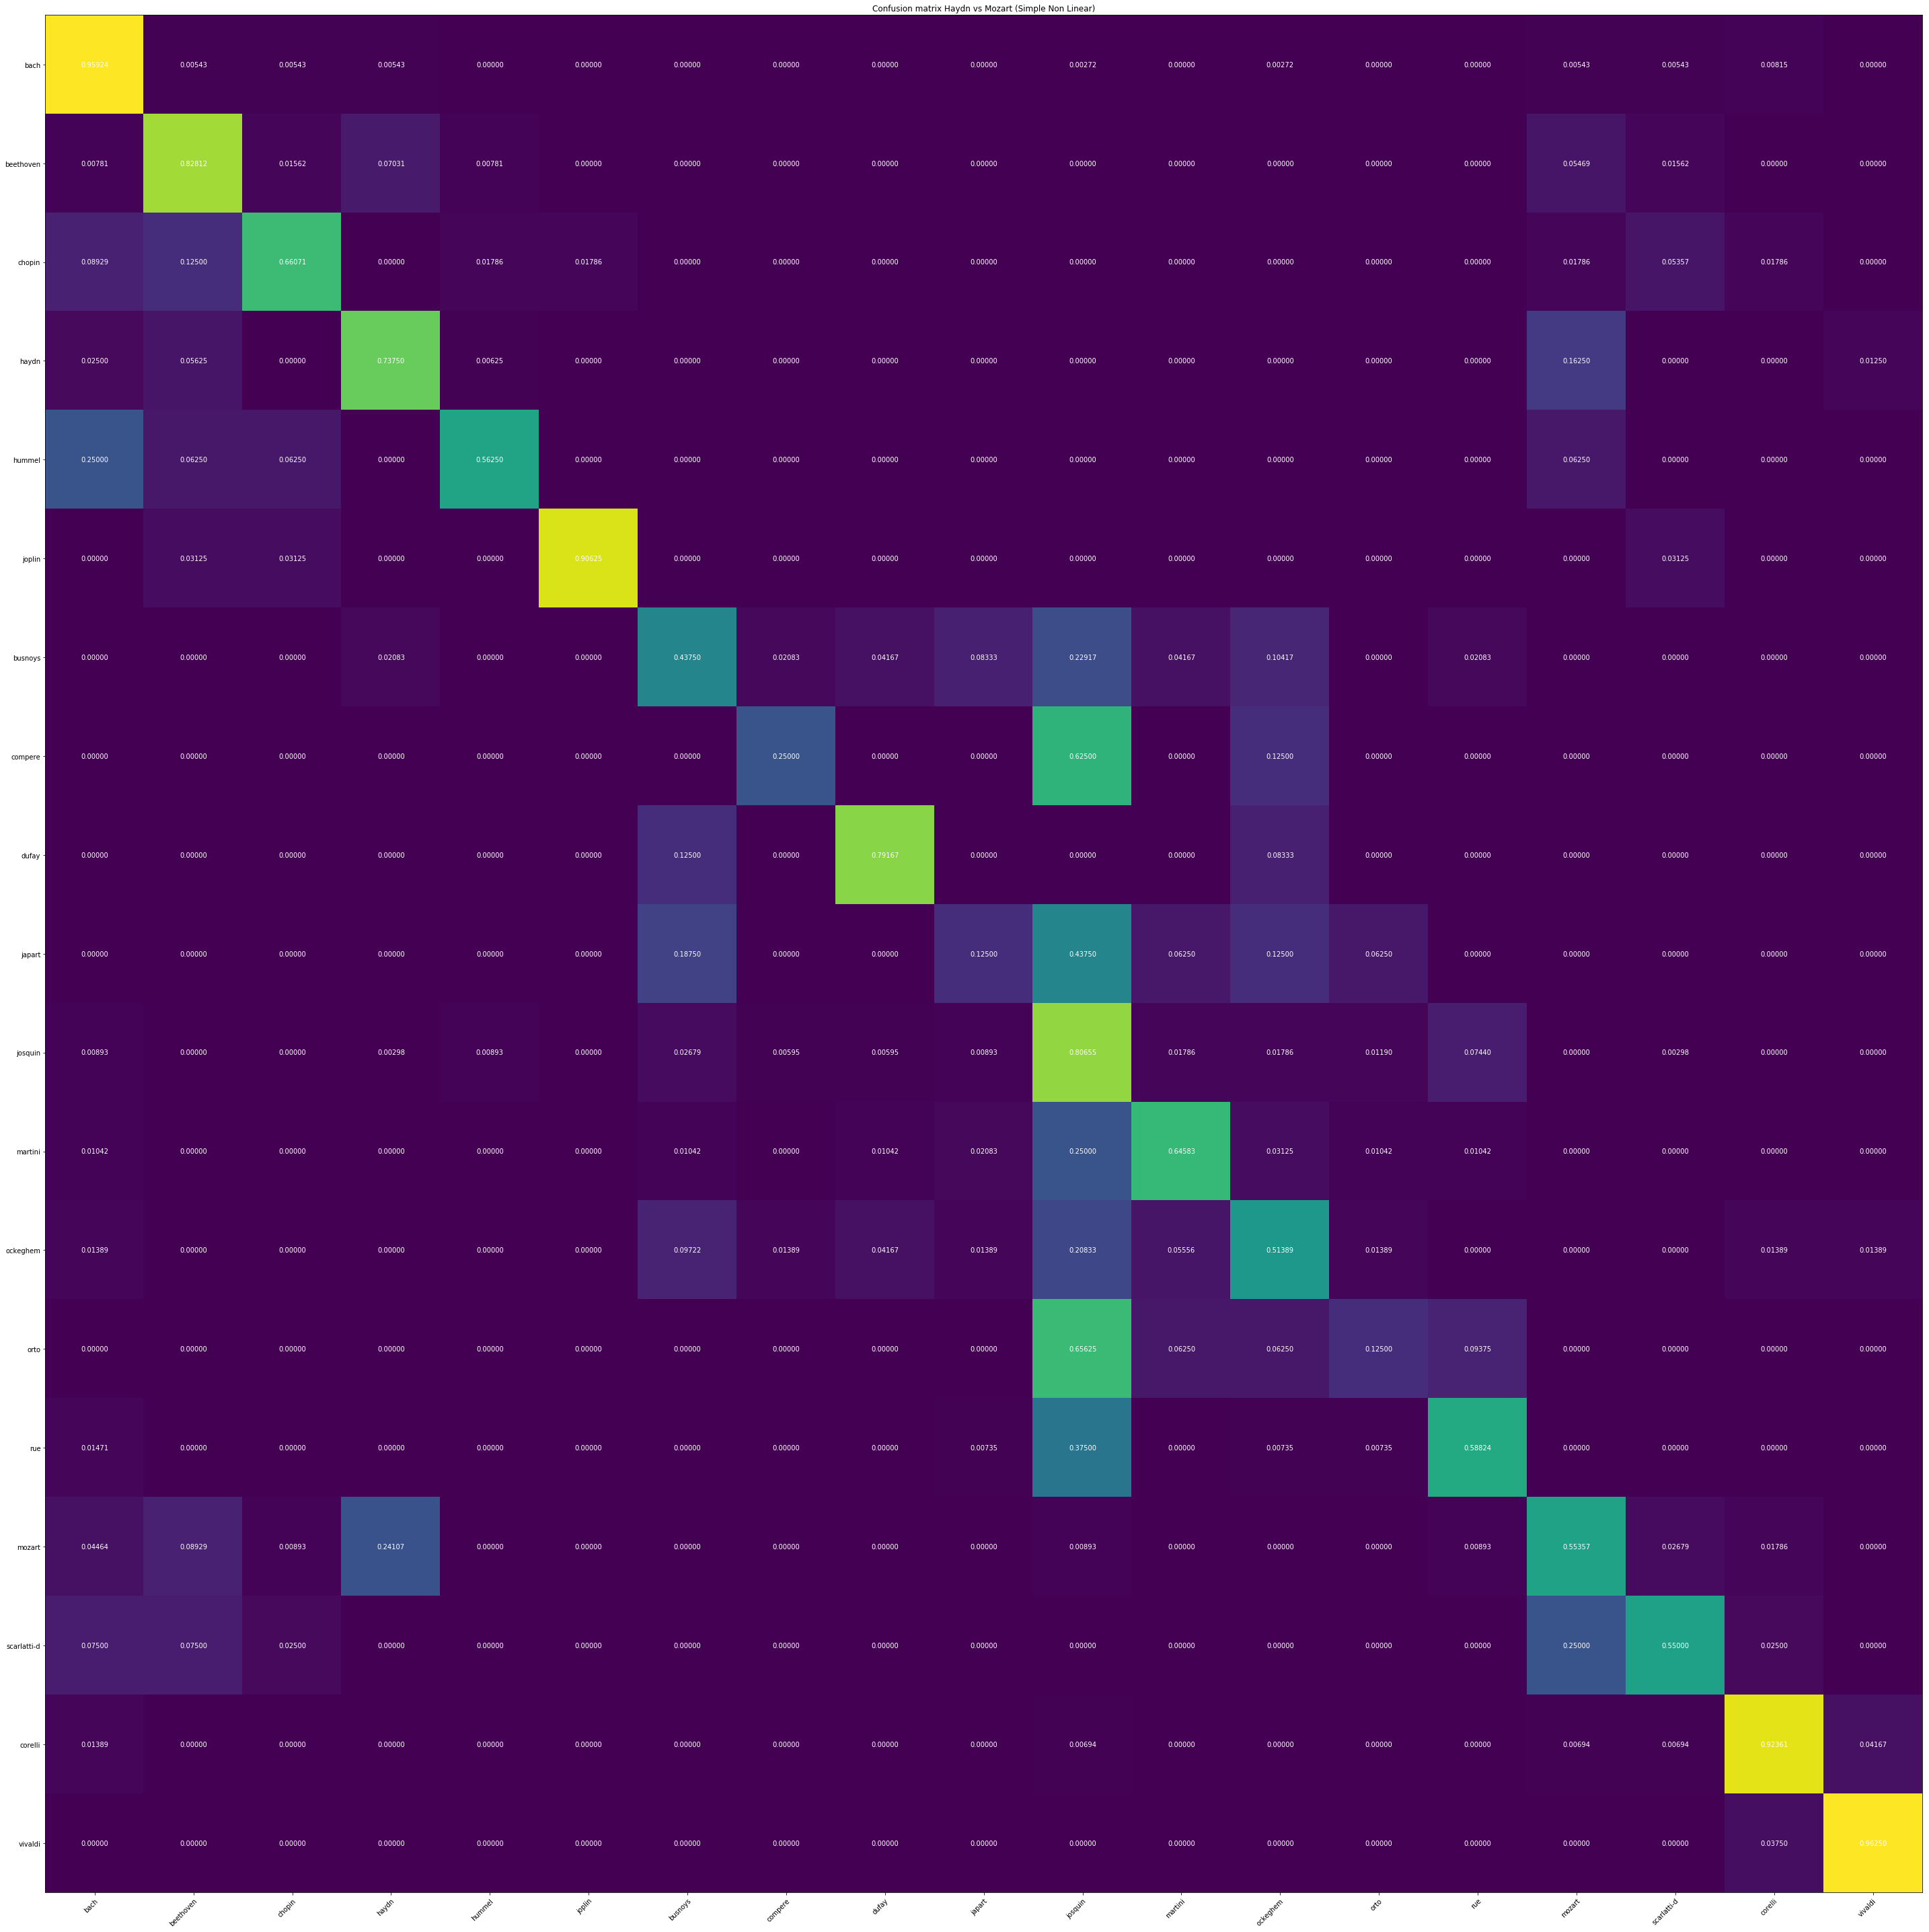

bach 44 / 46 = 0.9565217391304348
beethoven 14 / 16 = 0.875
busnoys 3 / 6 = 0.5
chopin 6 / 7 = 0.8571428571428571
compere 0 / 2 = 0.0
corelli 16 / 18 = 0.8888888888888888
dufay 2 / 3 = 0.6666666666666666
haydn 12 / 20 = 0.6
hummel 1 / 2 = 0.5
japart 1 / 2 = 0.5
joplin 3 / 4 = 0.75
josquin 33 / 42 = 0.7857142857142857
martini 5 / 12 = 0.4166666666666667
mozart 9 / 14 = 0.6428571428571429
ockeghem 3 / 9 = 0.3333333333333333
orto 1 / 4 = 0.25
rue 16 / 17 = 0.9411764705882353
scarlatti-d 2 / 5 = 0.4
vivaldi 10 / 10 = 1.0
181 239 0.7573221757322176
---------------------------------------------
---------------------------------------------
Fold 8
len validation_ids 400
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
In

96.00   75.62   3720    0.25    1.86    18.95   6.89    
95.50   75.62   3750    0.21    1.87    19.09   6.35    
96.00   74.52   3780    0.19    1.90    17.92   6.86    
96.50   75.07   3810    0.16    1.89    19.16   7.32    
96.00   75.07   3840    0.27    1.89    18.37   6.66    
96.00   75.90   3870    0.17    1.88    18.53   6.59    
96.00   74.52   3900    0.24    1.89    18.23   6.83    
96.00   74.79   3930    0.18    1.90    19.05   7.27    
96.00   74.24   3960    0.21    1.90    18.72   6.94    
96.00   74.24   3990    0.18    1.89    18.09   6.26    
96.00   74.52   4020    0.20    1.91    18.13   7.66    
96.00   73.96   4050    0.19    1.92    18.90   6.77    
96.00   74.24   4080    0.17    1.92    18.69   6.70    
96.00   74.79   4110    0.22    1.93    19.28   7.23    
96.00   74.52   4140    0.16    1.92    17.87   7.23    
96.00   74.79   4170    0.16    1.92    18.33   6.84    
96.00   74.79   4200    0.14    1.94    19.08   6.81    
96.00   75.07   4230    0.15   

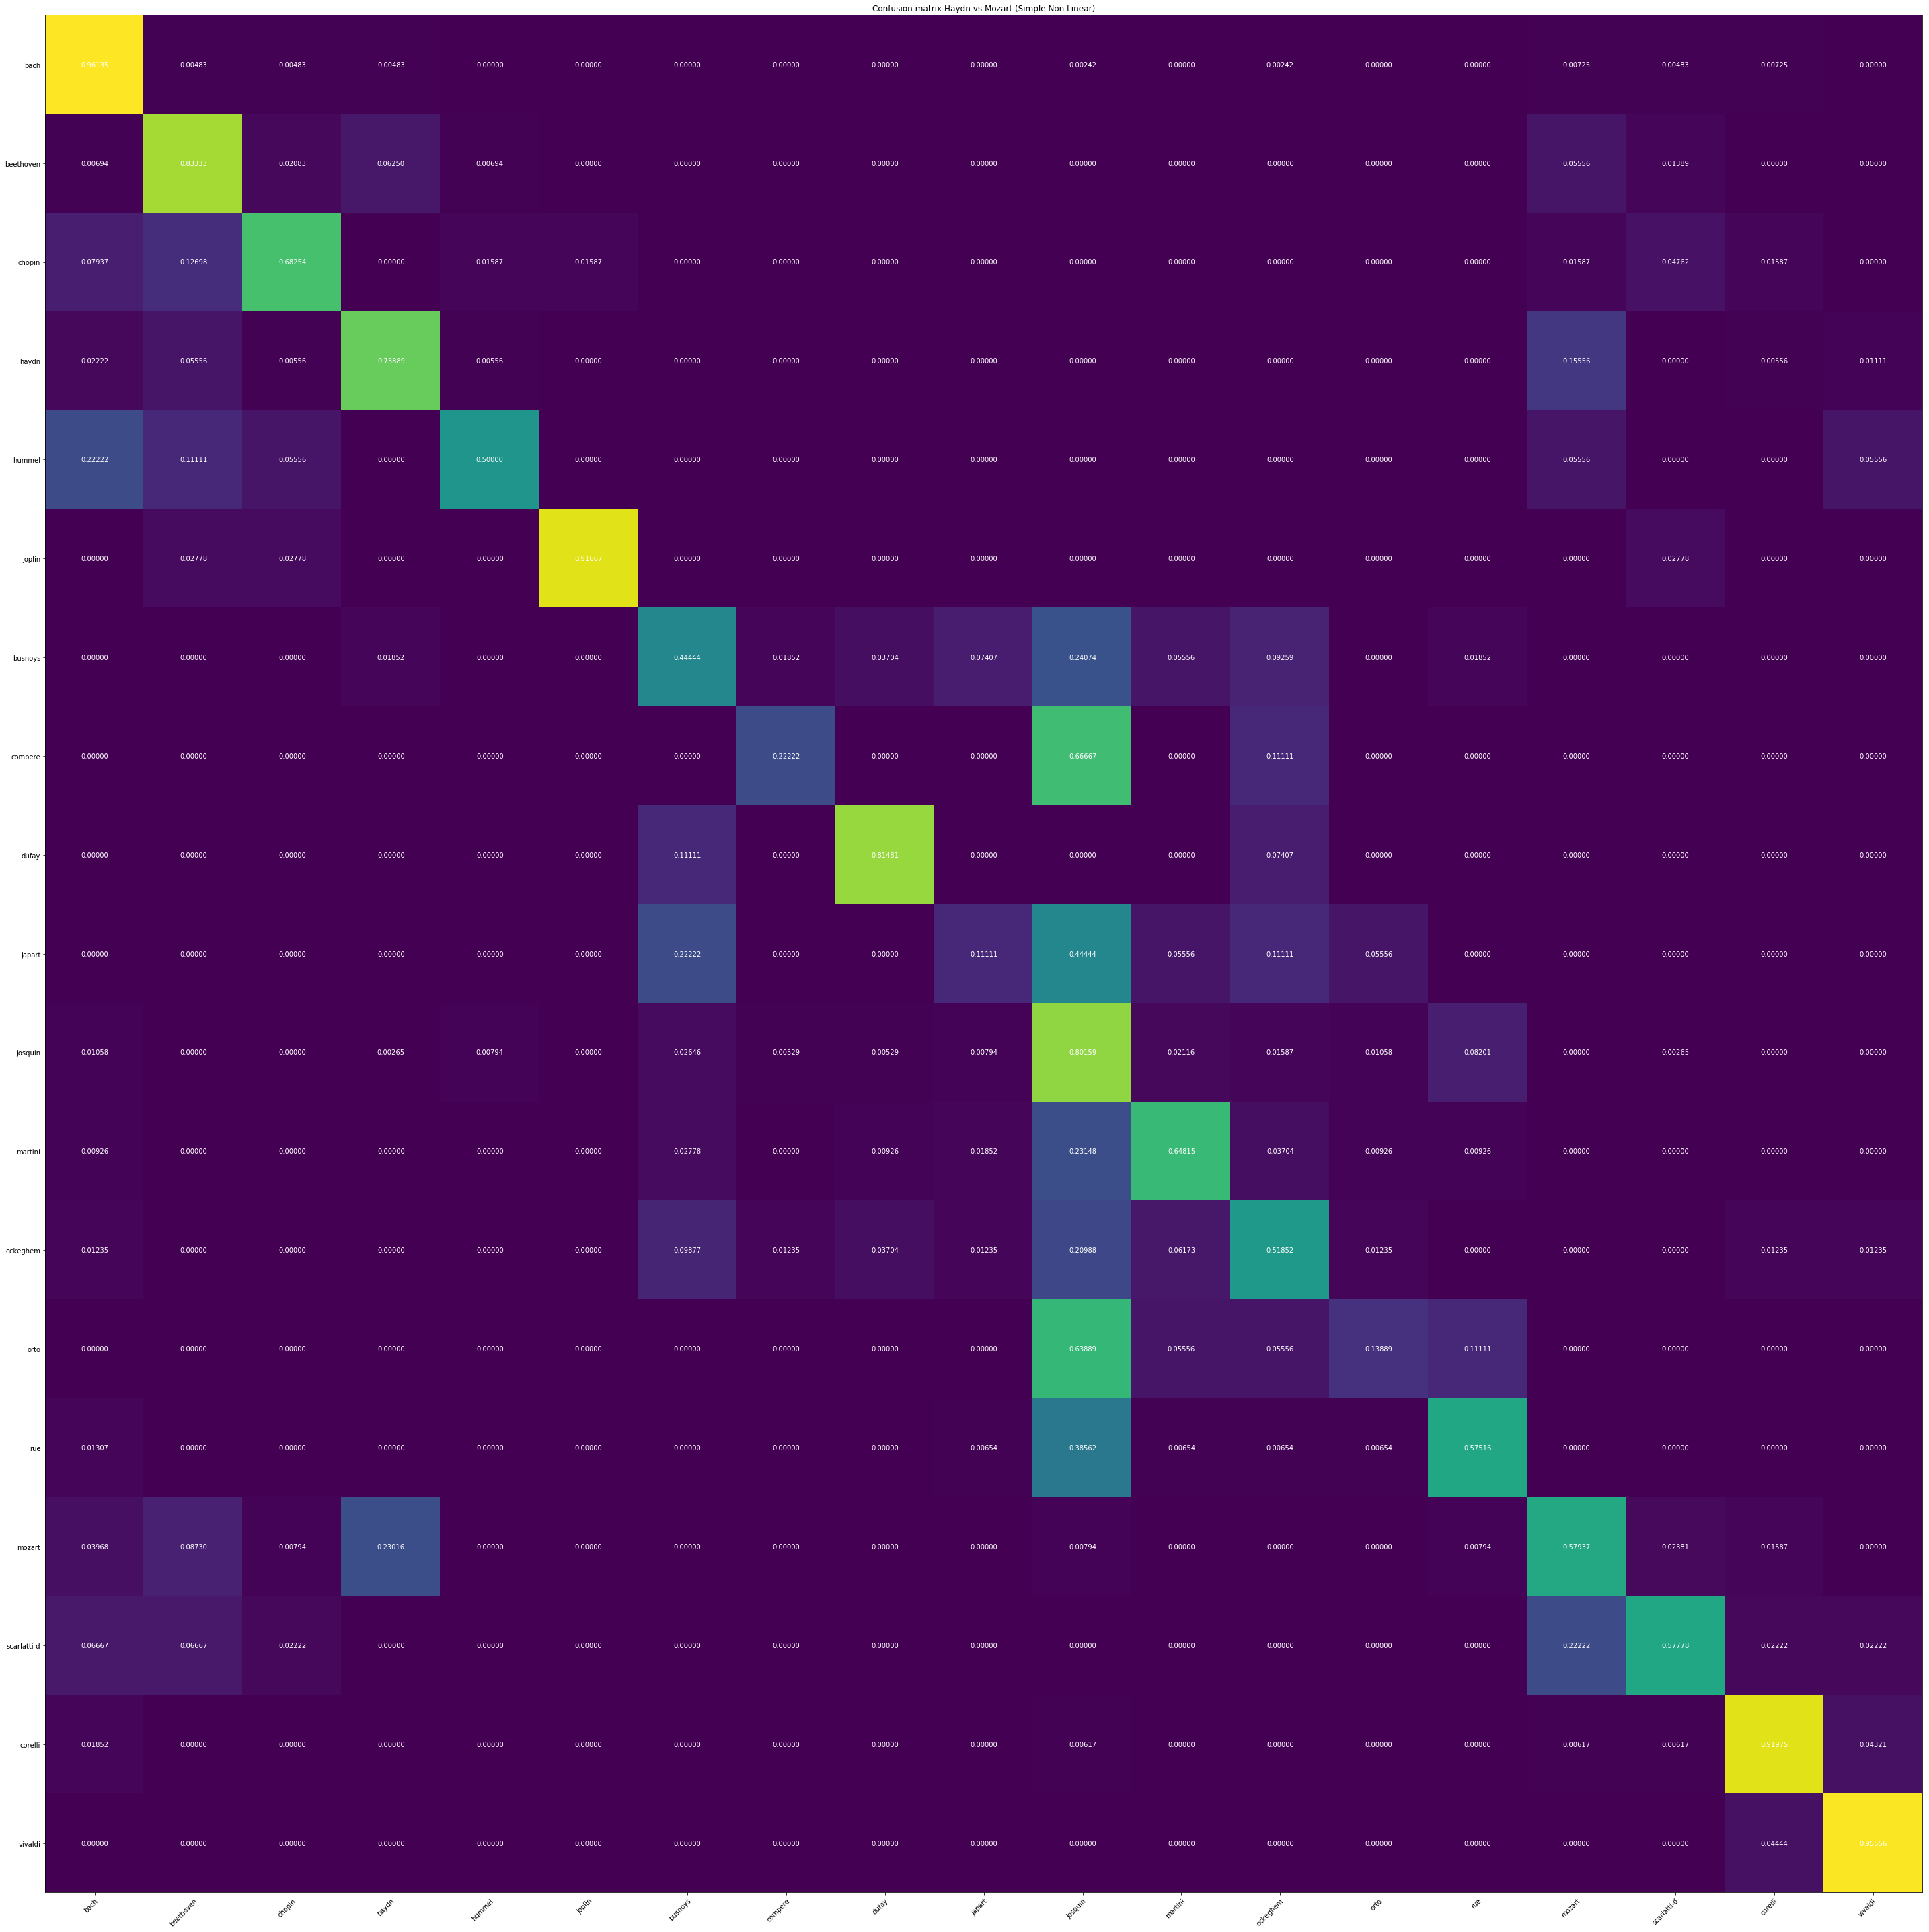

bach 45 / 46 = 0.9782608695652174
beethoven 14 / 16 = 0.875
busnoys 3 / 6 = 0.5
chopin 6 / 7 = 0.8571428571428571
compere 0 / 2 = 0.0
corelli 16 / 18 = 0.8888888888888888
dufay 3 / 3 = 1.0
haydn 15 / 20 = 0.75
hummel 0 / 2 = 0.0
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 32 / 42 = 0.7619047619047619
martini 8 / 12 = 0.6666666666666666
mozart 11 / 14 = 0.7857142857142857
ockeghem 5 / 9 = 0.5555555555555556
orto 1 / 4 = 0.25
rue 8 / 17 = 0.47058823529411764
scarlatti-d 4 / 5 = 0.8
vivaldi 9 / 10 = 0.9
184 239 0.7698744769874477
---------------------------------------------
---------------------------------------------
Fold 9
len validation_ids 246
len test_ids 400
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([500, 78, 1, 3]) (117000)
wdurations torch.Size([500, 55, 1, 3]) (82500)
w3 torch.Size([500, 19]) (9500)
bias torch.Size([19]) (19)
Initialized graph

97.00   79.50   3750    0.17    1.29    17.84   5.61    
97.00   79.50   3780    0.15    1.28    18.41   6.07    
97.50   79.08   3810    0.17    1.29    18.38   6.58    
97.50   78.24   3840    0.16    1.27    17.37   6.50    
97.00   79.92   3870    0.21    1.30    18.09   6.18    
97.50   79.50   3900    0.14    1.30    17.45   6.01    
97.50   79.08   3930    0.18    1.32    16.99   6.07    
97.50   79.08   3960    0.17    1.31    17.96   6.71    
98.00   79.92   3990    0.17    1.32    17.96   6.28    
97.50   78.24   4020    0.16    1.33    18.93   6.44    
98.00   79.50   4050    0.17    1.32    18.56   5.69    
98.00   78.66   4080    0.15    1.32    18.01   6.62    
98.00   79.08   4110    0.14    1.34    18.20   6.33    
97.50   77.41   4140    0.15    1.33    18.47   6.53    
97.50   79.92   4170    0.19    1.34    18.47   6.39    
97.50   79.08   4200    0.18    1.34    17.93   6.05    
97.00   77.82   4230    0.14    1.33    18.41   6.64    
98.50   79.92   4260    0.13   

100.00  79.50   8070    0.03    1.84    18.05   6.00    
100.00  79.92   8100    0.04    1.83    17.69   5.80    
100.00  79.50   8130    0.03    1.86    17.35   5.98    
100.00  81.17   8160    0.04    1.85    17.20   5.92    
100.00  81.17   8190    0.05    1.83    18.07   5.58    
100.00  81.17   8220    0.03    1.85    16.87   5.61    
100.00  81.17   8250    0.03    1.85    18.06   5.70    
100.00  82.01   8280    0.03    1.86    17.65   6.09    
100.00  80.33   8310    0.03    1.86    17.69   5.82    
100.00  81.17   8340    0.02    1.88    17.67   5.97    
100.00  81.17   8370    0.03    1.87    17.11   5.68    
100.00  80.75   8400    0.03    1.89    17.10   6.25    
100.00  80.33   8430    0.03    1.88    18.23   6.02    
100.00  79.50   8460    0.03    1.90    17.29   6.71    
100.00  80.33   8490    0.02    1.91    16.55   6.29    
100.00  79.50   8520    0.03    1.91    18.53   6.46    
100.00  79.50   8550    0.03    1.92    17.98   6.64    
100.00  79.50   8580    0.03   

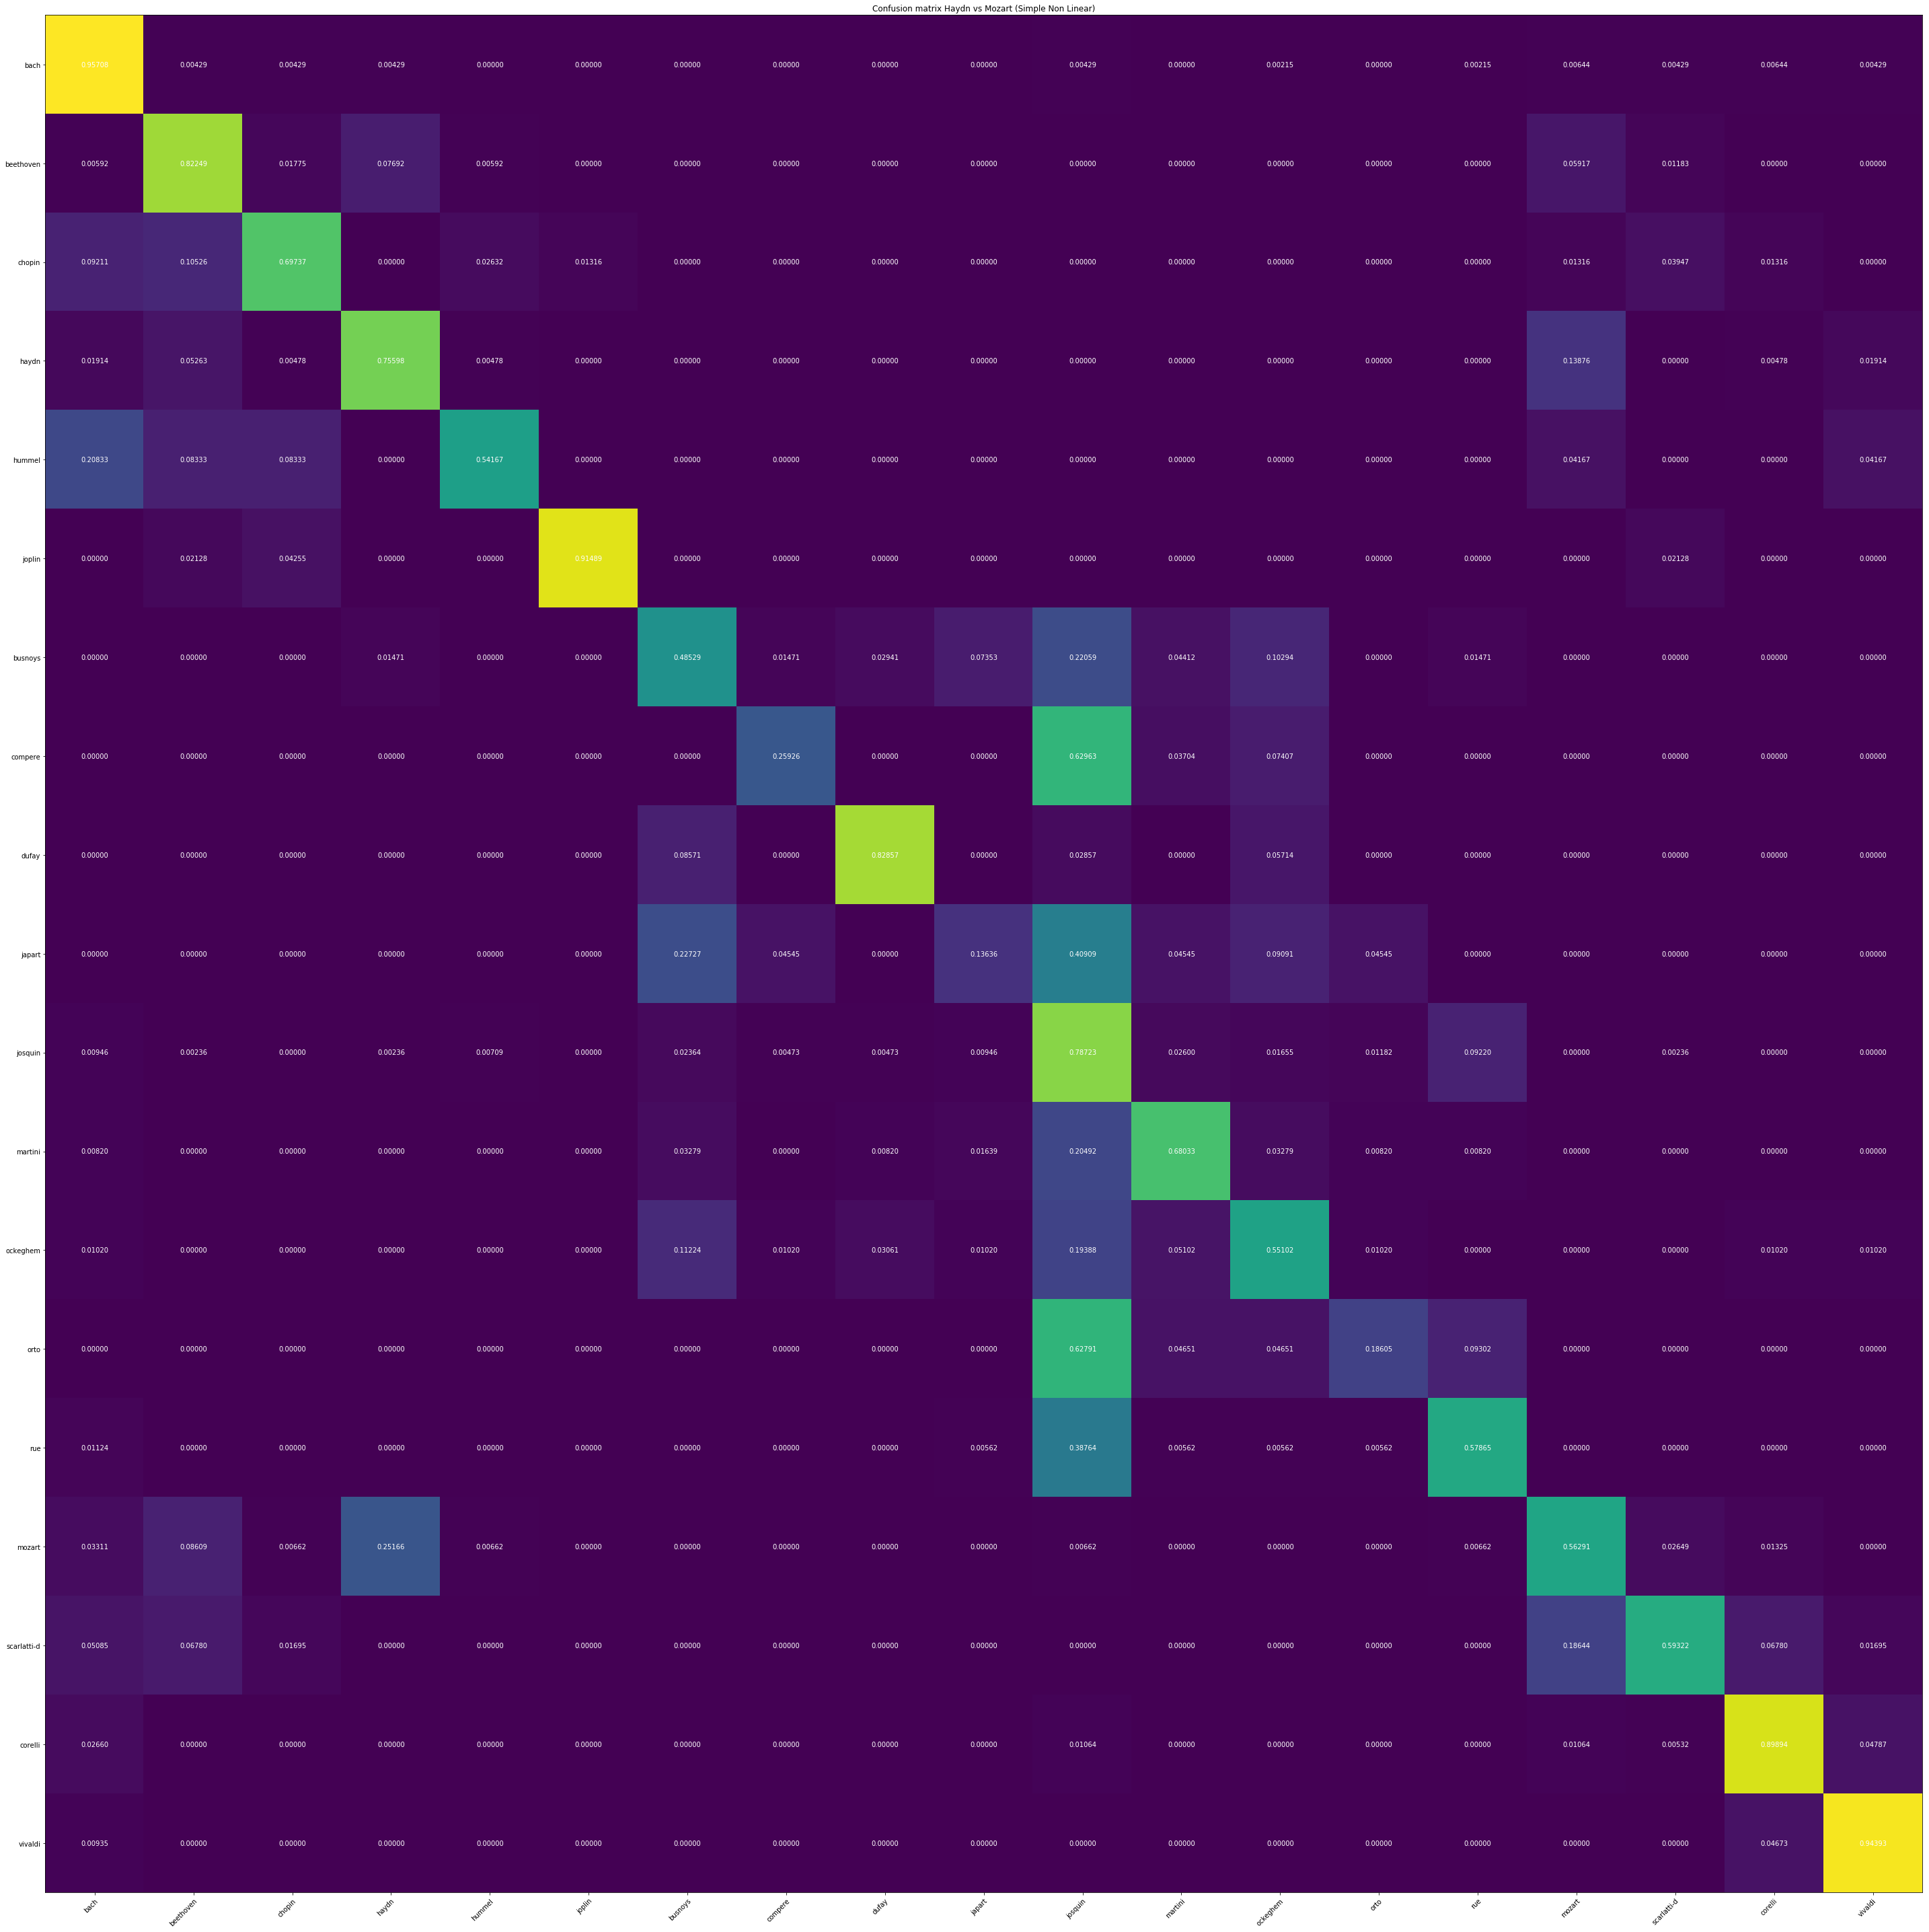

bach 48 / 52 = 0.9230769230769231
beethoven 19 / 25 = 0.76
busnoys 9 / 14 = 0.6428571428571429
chopin 10 / 13 = 0.7692307692307693
compere 3 / 9 = 0.3333333333333333
corelli 20 / 26 = 0.7692307692307693
dufay 7 / 8 = 0.875
haydn 25 / 29 = 0.8620689655172413
hummel 4 / 6 = 0.6666666666666666
japart 1 / 4 = 0.25
joplin 10 / 11 = 0.9090909090909091
josquin 30 / 45 = 0.6666666666666666
martini 13 / 14 = 0.9285714285714286
mozart 12 / 25 = 0.48
ockeghem 12 / 17 = 0.7058823529411765
orto 3 / 7 = 0.42857142857142855
rue 15 / 25 = 0.6
scarlatti-d 9 / 14 = 0.6428571428571429
vivaldi 15 / 17 = 0.8823529411764706
265 361 0.7340720221606648


In [5]:
validator.run(context, checkpoint_dir=checkpoint_dir)

In [1]:
(265 + 184 + 181 + 181 + 184 + 184 + 183 + 175 + 188 + 170)/ (361 + 239 + 239 + 239 + 239 + 239 + 239 + 239 + 239 + 239)

0.7543789808917197